In [7]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')


from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant


## Question 2 - A

## Question (i): Simulation des séries AR

Création d'une procédure pour simuler 200 valeurs de différentes séries AR avec des erreurs i.i.d. N(0,1)

In [8]:
def simulate_ar(n=200, phi=None, constant=0, phi2=None, seed=None):
    """
    Simule une série temporelle AR avec des erreurs i.i.d. N(0,1)
    
    Paramètres:
    -----------
    n : int
        Nombre de valeurs à simuler (par défaut 200)
    phi : float
        Coefficient AR(1) (par défaut None)
    constant : float
        Constante dans le modèle (par défaut 0)
    phi2 : float
        Coefficient AR(2) pour les modèles d'ordre 2 (par défaut None)
    seed : int
        Graine pour la reproductibilité (par défaut None)
    
    Retourne:
    ---------
    y : array
        Série temporelle simulée
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Génération des erreurs i.i.d. N(0,1)
    errors = np.random.normal(0, 1, n)
    
    # Initialisation de la série
    y = np.zeros(n)
    
    # Valeurs initiales
    y[0] = errors[0]
    if phi2 is not None and n > 1:
        y[1] = constant + phi * y[0] + errors[1] if phi is not None else errors[1]
    
    # Génération de la série
    if phi2 is not None:  # Modèle AR(2)
        for t in range(2, n):
            y[t] = constant + phi * y[t-1] + phi2 * y[t-2] + errors[t]
    else:  # Modèle AR(1)
        for t in range(1, n):
            y[t] = constant + phi * y[t-1] + errors[t] if phi is not None else constant + y[t-1] + errors[t]
    
    return y

In [9]:
# Simulation des 5 séries AR avec seed pour reproductibilité
np.random.seed(42)

# 1. y_t = y_{t-1} + e_t (Random Walk)
y1 = simulate_ar(n=200, phi=1.0, constant=0, seed=42)

# 2. y_t = 0.98 · y_{t-1} + e_t
y2 = simulate_ar(n=200, phi=0.98, constant=0, seed=43)

# 3. y_t = 0.90 · y_{t-1} + e_t
y3 = simulate_ar(n=200, phi=0.90, constant=0, seed=44)

# 4. y_t = 0.1 + y_{t-1} + e_t (Random Walk avec dérive)
y4 = simulate_ar(n=200, phi=1.0, constant=0.1, seed=45)

# 5. y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t
y5 = simulate_ar(n=200, phi=1.25, constant=0, phi2=-0.27, seed=46)

print("Séries AR simulées avec succès!")
print(f"Série 1 (Random Walk): min={y1.min():.2f}, max={y1.max():.2f}")
print(f"Série 2 (φ=0.98): min={y2.min():.2f}, max={y2.max():.2f}")
print(f"Série 3 (φ=0.90): min={y3.min():.2f}, max={y3.max():.2f}")
print(f"Série 4 (Random Walk avec dérive): min={y4.min():.2f}, max={y4.max():.2f}")
print(f"Série 5 (AR(2)): min={y5.min():.2f}, max={y5.max():.2f}")

Séries AR simulées avec succès!
Série 1 (Random Walk): min=-13.53, max=4.48
Série 2 (φ=0.98): min=-7.28, max=8.74
Série 3 (φ=0.90): min=-5.17, max=4.60
Série 4 (Random Walk avec dérive): min=-10.20, max=16.44
Série 5 (AR(2)): min=-9.11, max=15.90


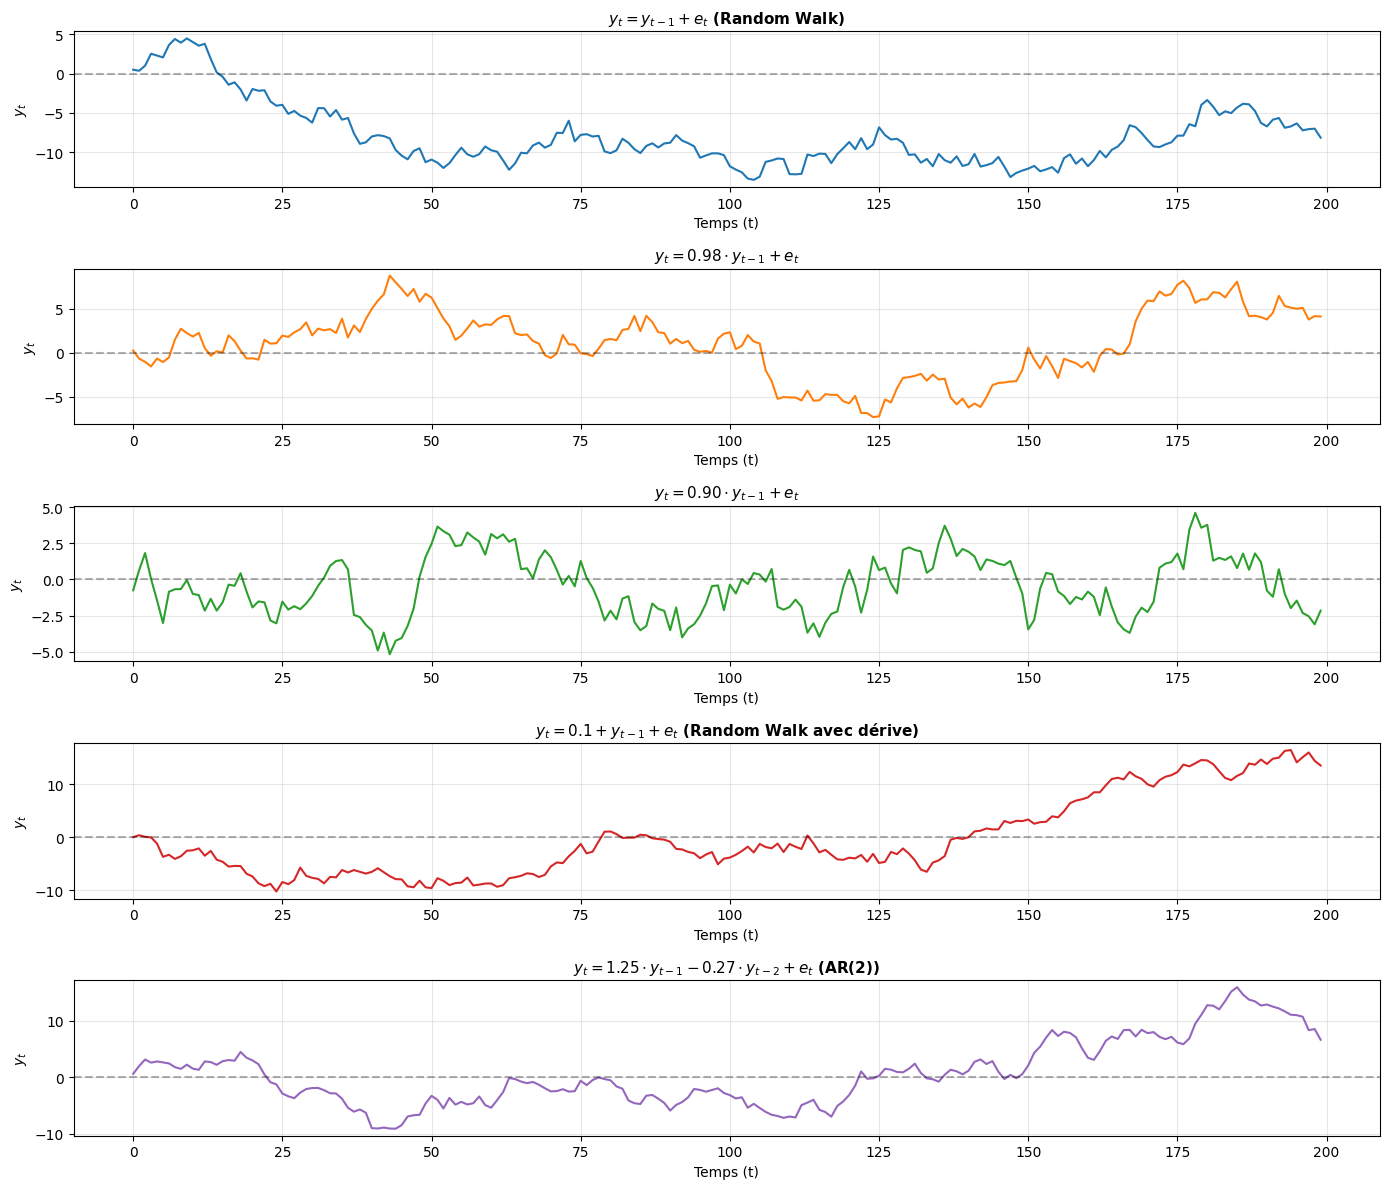

In [10]:
# Visualisation des séries temporelles simulées
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

series = [y1, y2, y3, y4, y5]
titles = [
    r'$y_t = y_{t-1} + e_t$ (Random Walk)',
    r'$y_t = 0.98 \cdot y_{t-1} + e_t$',
    r'$y_t = 0.90 \cdot y_{t-1} + e_t$',
    r'$y_t = 0.1 + y_{t-1} + e_t$ (Random Walk avec dérive)',
    r'$y_t = 1.25 \cdot y_{t-1} - 0.27 \cdot y_{t-2} + e_t$ (AR(2))'
]

for i, (y, title) in enumerate(zip(series, titles)):
    axes[i].plot(y, linewidth=1.5, color=f'C{i}')
    axes[i].set_title(title, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Temps (t)')
    axes[i].set_ylabel('$y_t$')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Discussion des graphiques des séries AR simulées

**Analyse des caractéristiques de chaque série:**

1. **y_t = y_{t-1} + e_t (Random Walk)**
   - Série non-stationnaire avec racine unitaire (φ = 1)
   - Variance croissante au fil du temps
   - Pas de tendance à retourner vers une moyenne
   - Comportement imprévisible à long terme

2. **y_t = 0.98 · y_{t-1} + e_t**
   - Série quasi non-stationnaire (φ très proche de 1)
   - Persistance élevée des chocs
   - Retour très lent vers la moyenne
   - Comportement similaire à une marche aléatoire

3. **y_t = 0.90 · y_{t-1} + e_t**
   - Série stationnaire (|φ| < 1)
   - Retour à la moyenne plus rapide
   - Variance stable
   - Oscillations autour de zéro

4. **y_t = 0.1 + y_{t-1} + e_t (Random Walk avec dérive)**
   - Série non-stationnaire avec tendance déterministe
   - Croissance linéaire en moyenne
   - Variance croissante au fil du temps
   - Dérive positive de 0.1 par période

5. **y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t (AR(2))**
   - Processus AR(2) potentiellement explosif ou oscillant
   - Comportement dépend des racines caractéristiques
   - Peut montrer des oscillations selon les valeurs des coefficients

In [11]:
# Analyse statistique des séries simulées
print("Statistiques descriptives des séries AR simulées:\n")
print("="*80)

for i, (y, title) in enumerate(zip(series, titles), 1):
    print(f"\nSérie {i}: {title}")
    print(f"  Moyenne: {np.mean(y):.4f}")
    print(f"  Écart-type: {np.std(y):.4f}")
    print(f"  Min: {np.min(y):.4f}")
    print(f"  Max: {np.max(y):.4f}")
    print(f"  Étendue: {np.max(y) - np.min(y):.4f}")
    
    # Test ADF pour la stationnarité
    adf_result = adfuller(y)
    print(f"  Test ADF p-value: {adf_result[1]:.4f} {'(Stationnaire)' if adf_result[1] < 0.05 else '(Non-stationnaire)'}")

Statistiques descriptives des séries AR simulées:


Série 1: $y_t = y_{t-1} + e_t$ (Random Walk)
  Moyenne: -7.9166
  Écart-type: 4.0409
  Min: -13.5269
  Max: 4.4806
  Étendue: 18.0076
  Test ADF p-value: 0.1696 (Non-stationnaire)

Série 2: $y_t = 0.98 \cdot y_{t-1} + e_t$
  Moyenne: 0.9708
  Écart-type: 3.7874
  Min: -7.2751
  Max: 8.7433
  Étendue: 16.0184
  Test ADF p-value: 0.3780 (Non-stationnaire)

Série 3: $y_t = 0.90 \cdot y_{t-1} + e_t$
  Moyenne: -0.4439
  Écart-type: 2.0399
  Min: -5.1652
  Max: 4.6045
  Étendue: 9.7697
  Test ADF p-value: 0.0027 (Stationnaire)

Série 4: $y_t = 0.1 + y_{t-1} + e_t$ (Random Walk avec dérive)
  Moyenne: -0.3198
  Écart-type: 7.3615
  Min: -10.1979
  Max: 16.4392
  Étendue: 26.6371
  Test ADF p-value: 0.9598 (Non-stationnaire)

Série 5: $y_t = 1.25 \cdot y_{t-1} - 0.27 \cdot y_{t-2} + e_t$ (AR(2))
  Moyenne: 0.6604
  Écart-type: 5.7588
  Min: -9.1068
  Max: 15.9034
  Étendue: 25.0103
  Test ADF p-value: 0.5559 (Non-stationnaire)


## Question 2 - B: Simulations de Monte Carlo des tests ADF et KPSS

Simulation de Monte Carlo avec 5000 réplications pour chaque modèle AR, testant:
- Test ADF (Augmented Dickey-Fuller) avec regression="c" et "ct"
- Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin) avec regression="c" et "ct"
- Paramètres: nlags=2 pour KPSS, maxlag=2 et autolags=None pour ADF
- Calcul des taux de rejet au niveau de 5%

In [12]:
# Import du test KPSS
from statsmodels.tsa.stattools import kpss

In [13]:
def monte_carlo_unit_root_tests(n_simulations=5000, n_obs=200, phi=None, constant=0, phi2=None):
    """
    Effectue des simulations de Monte Carlo pour les tests ADF et KPSS
    
    Paramètres:
    -----------
    n_simulations : int
        Nombre de réplications Monte Carlo
    n_obs : int
        Nombre d'observations par série simulée
    phi : float
        Coefficient AR(1)
    constant : float
        Constante dans le modèle
    phi2 : float
        Coefficient AR(2) (si applicable)
    
    Retourne:
    ---------
    results : dict
        Dictionnaire contenant les taux de rejet pour chaque test
    """
    
    # Initialisation des compteurs de rejets
    rejections = {
        'ADF_c': 0,      # ADF avec constante
        'ADF_ct': 0,     # ADF avec constante et tendance
        'KPSS_c': 0,     # KPSS avec constante
        'KPSS_ct': 0     # KPSS avec constante et tendance
    }
    
    # Valeurs critiques à 5%
    adf_critical_5pct = -2.86  # Approximativement pour n=200
    kpss_critical_5pct_c = 0.463   # KPSS avec constante
    kpss_critical_5pct_ct = 0.146  # KPSS avec tendance
    
    for i in range(n_simulations):
        # Simulation d'une série AR
        y = simulate_ar(n=n_obs, phi=phi, constant=constant, phi2=phi2, seed=None)
        
        try:
            # Test ADF avec regression="c" (constante seulement)
            adf_result_c = adfuller(y, maxlag=2, regression='c', autolag=None)
            if adf_result_c[0] < adf_critical_5pct:  # Statistique < valeur critique -> rejet H0
                rejections['ADF_c'] += 1
            
            # Test ADF avec regression="ct" (constante et tendance)
            adf_result_ct = adfuller(y, maxlag=2, regression='ct', autolag=None)
            if adf_result_ct[0] < adf_critical_5pct:  # Statistique < valeur critique -> rejet H0
                rejections['ADF_ct'] += 1
            
            # Test KPSS avec regression="c" (constante seulement)
            kpss_result_c = kpss(y, regression='c', nlags=2)
            if kpss_result_c[0] > kpss_critical_5pct_c:  # Statistique > valeur critique -> rejet H0
                rejections['KPSS_c'] += 1
            
            # Test KPSS avec regression="ct" (constante et tendance)
            kpss_result_ct = kpss(y, regression='ct', nlags=2)
            if kpss_result_ct[0] > kpss_critical_5pct_ct:  # Statistique > valeur critique -> rejet H0
                rejections['KPSS_ct'] += 1
                
        except Exception as e:
            # En cas d'erreur, continuer avec la prochaine simulation
            continue
    
    # Calcul des taux de rejet (en pourcentage)
    rejection_rates = {
        test: (count / n_simulations) * 100 
        for test, count in rejections.items()
    }
    
    return rejection_rates

In [14]:
# Configuration des 5 modèles AR
models = [
    {'name': 'y_t = y_{t-1} + e_t (Random Walk)', 'phi': 1.0, 'constant': 0, 'phi2': None},
    {'name': 'y_t = 0.98 · y_{t-1} + e_t', 'phi': 0.98, 'constant': 0, 'phi2': None},
    {'name': 'y_t = 0.90 · y_{t-1} + e_t', 'phi': 0.90, 'constant': 0, 'phi2': None},
    {'name': 'y_t = 0.1 + y_{t-1} + e_t (RW avec dérive)', 'phi': 1.0, 'constant': 0.1, 'phi2': None},
    {'name': 'y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t (AR(2))', 'phi': 1.25, 'constant': 0, 'phi2': -0.27}
]

# Exécution des simulations Monte Carlo
print("Démarrage des simulations de Monte Carlo (5000 réplications par modèle)...")
print("Cela peut prendre quelques minutes...\n")

results_all_models = {}

for i, model in enumerate(models, 1):
    print(f"Simulation du modèle {i}/5: {model['name']}")
    
    results = monte_carlo_unit_root_tests(
        n_simulations=5000,
        n_obs=200,
        phi=model['phi'],
        constant=model['constant'],
        phi2=model['phi2']
    )
    
    results_all_models[model['name']] = results
    print(f"  ✓ Complété\n")

print("Toutes les simulations sont terminées!")

Démarrage des simulations de Monte Carlo (5000 réplications par modèle)...
Cela peut prendre quelques minutes...

Simulation du modèle 1/5: y_t = y_{t-1} + e_t (Random Walk)
  ✓ Complété

Simulation du modèle 2/5: y_t = 0.98 · y_{t-1} + e_t
  ✓ Complété

Simulation du modèle 3/5: y_t = 0.90 · y_{t-1} + e_t
  ✓ Complété

Simulation du modèle 4/5: y_t = 0.1 + y_{t-1} + e_t (RW avec dérive)
  ✓ Complété

Simulation du modèle 5/5: y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t (AR(2))
  ✓ Complété

Toutes les simulations sont terminées!


In [15]:
# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results_all_models).T
results_df.columns = ['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)']

# Noms de modèles plus courts pour l'affichage
model_names_short = [
    'RW: φ=1.0',
    'AR(1): φ=0.98',
    'AR(1): φ=0.90',
    'RW+dérive: φ=1.0, c=0.1',
    'AR(2): φ₁=1.25, φ₂=-0.27'
]
results_df.index = model_names_short

print("\n" + "="*80)
print("TAUX DE REJET À 5% - SIMULATIONS MONTE CARLO (5000 réplications)")
print("="*80)
print("\nNote: Les valeurs sont en pourcentage (%)")
print("\n" + results_df.to_string())
print("\n" + "="*80)


TAUX DE REJET À 5% - SIMULATIONS MONTE CARLO (5000 réplications)

Note: Les valeurs sont en pourcentage (%)

                          ADF (c)  ADF (ct)  KPSS (c)  KPSS (ct)
RW: φ=1.0                    5.42     18.10     98.50      99.28
AR(1): φ=0.98                9.34     23.96     95.40      99.06
AR(1): φ=0.90               76.84     85.28     69.82      88.76
RW+dérive: φ=1.0, c=0.1      3.08     18.10     99.46      99.46
AR(2): φ₁=1.25, φ₂=-0.27    12.80     28.10     93.98      98.94



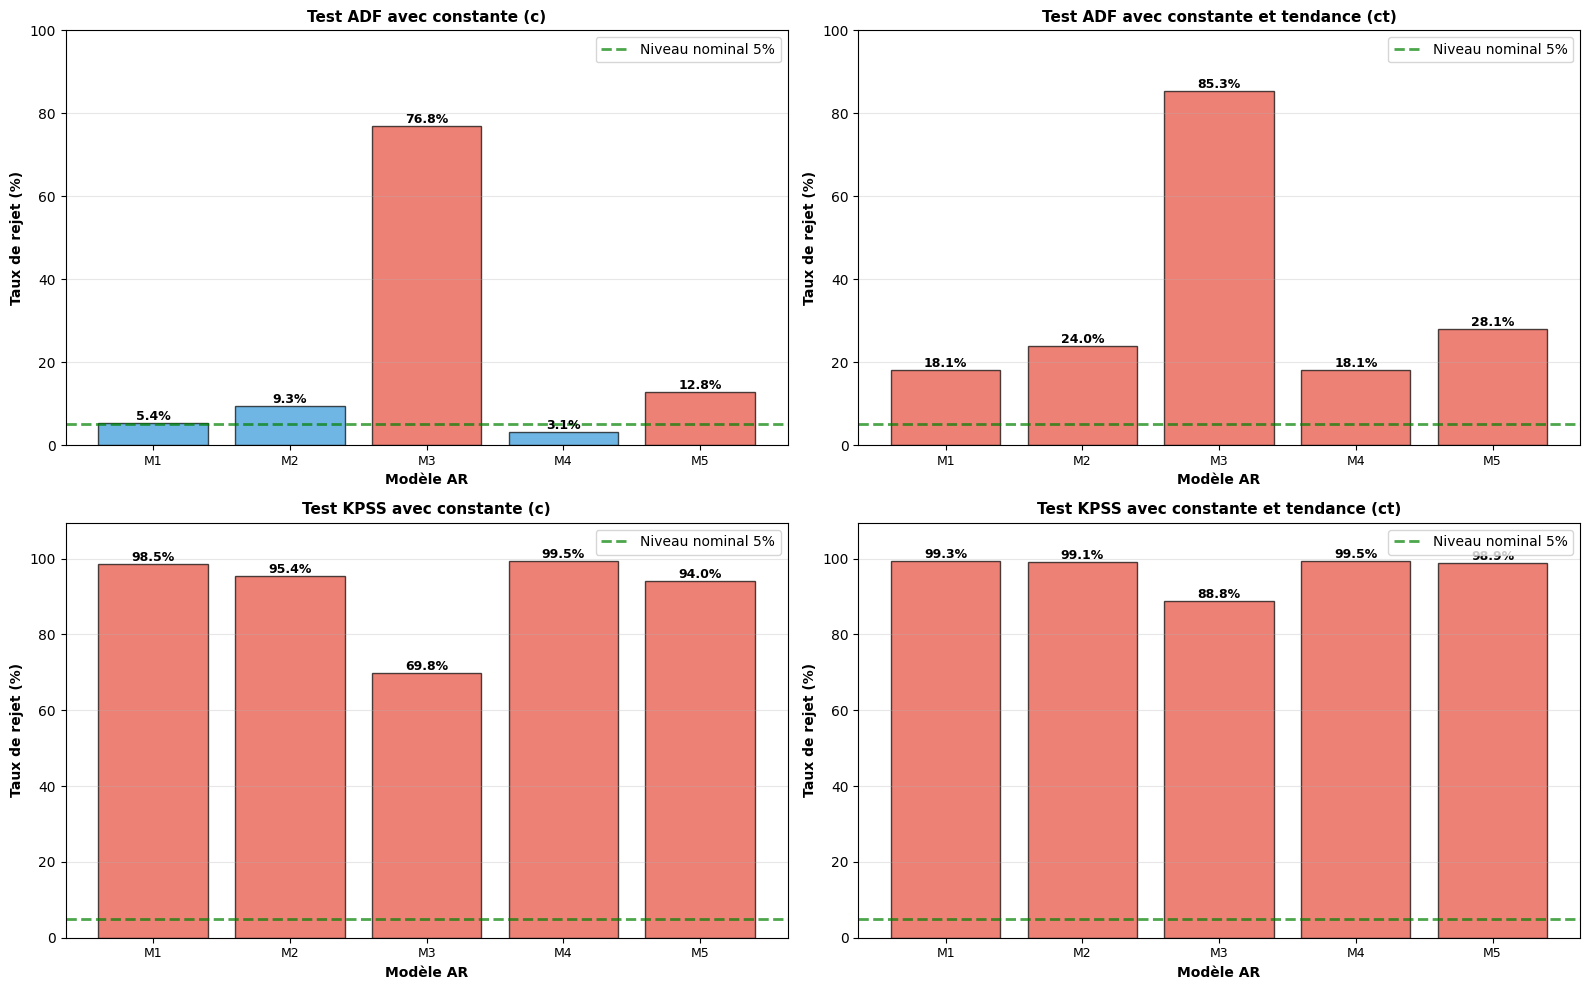


Légende des modèles:
  M1: RW: φ=1.0
  M2: AR(1): φ=0.98
  M3: AR(1): φ=0.90
  M4: RW+dérive: φ=1.0, c=0.1
  M5: AR(2): φ₁=1.25, φ₂=-0.27


In [16]:
# Visualisation des taux de rejet
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

tests = ['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)']
test_titles = [
    'Test ADF avec constante (c)',
    'Test ADF avec constante et tendance (ct)',
    'Test KPSS avec constante (c)',
    'Test KPSS avec constante et tendance (ct)'
]

for idx, (test, title) in enumerate(zip(tests, test_titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Données pour le graphique
    rejection_rates = results_df[test].values
    colors = ['#e74c3c' if rate > 10 else '#3498db' for rate in rejection_rates]
    
    # Création du graphique à barres
    bars = ax.bar(range(len(model_names_short)), rejection_rates, color=colors, alpha=0.7, edgecolor='black')
    
    # Ligne de référence à 5%
    ax.axhline(y=5, color='green', linestyle='--', linewidth=2, label='Niveau nominal 5%', alpha=0.7)
    
    # Ajout des valeurs sur les barres
    for i, (bar, rate) in enumerate(zip(bars, rejection_rates)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Modèle AR', fontsize=10, fontweight='bold')
    ax.set_ylabel('Taux de rejet (%)', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks(range(len(model_names_short)))
    ax.set_xticklabels([f'M{i+1}' for i in range(len(model_names_short))], fontsize=9)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(100, max(rejection_rates) * 1.1))

plt.tight_layout()
plt.show()

# Légende des modèles
print("\nLégende des modèles:")
for i, name in enumerate(model_names_short, 1):
    print(f"  M{i}: {name}")

### Interprétation des résultats des simulations Monte Carlo

#### Rappel des hypothèses des tests:

**Test ADF (Augmented Dickey-Fuller):**
- H₀: La série a une racine unitaire (non-stationnaire)
- H₁: La série est stationnaire
- On rejette H₀ si la statistique ADF < valeur critique (rejet = série stationnaire)

**Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin):**
- H₀: La série est stationnaire
- H₁: La série a une racine unitaire (non-stationnaire)
- On rejette H₀ si la statistique KPSS > valeur critique (rejet = série non-stationnaire)

#### Analyse par modèle:

**Modèle 1: Random Walk (φ=1.0)**
- Série non-stationnaire par construction
- ADF devrait avoir un faible taux de rejet (ne devrait pas rejeter H₀)
- KPSS devrait avoir un taux de rejet élevé (devrait rejeter H₀)

**Modèle 2: AR(1) avec φ=0.98**
- Série techniquement stationnaire mais très persistante
- Proche d'une racine unitaire
- Taux de rejet intermédiaires attendus

**Modèle 3: AR(1) avec φ=0.90**
- Série clairement stationnaire
- ADF devrait avoir un taux de rejet élevé (devrait rejeter H₀)
- KPSS devrait avoir un faible taux de rejet (ne devrait pas rejeter H₀)

**Modèle 4: Random Walk avec dérive (φ=1.0, c=0.1)**
- Série non-stationnaire avec tendance déterministe
- Comportement similaire au modèle 1, mais avec tendance
- Test "ct" peut mieux détecter la non-stationnarité

**Modèle 5: AR(2) avec φ₁=1.25, φ₂=-0.27**
- Racines caractéristiques à vérifier
- Somme des coefficients: 1.25 - 0.27 = 0.98 < 1 (suggère stationnarité)
- Comportement peut être oscillant

In [17]:
# Résumé détaillé des résultats
print("\n" + "="*80)
print("RÉSUMÉ ET CONCLUSIONS")
print("="*80)

for i, (model_name, short_name) in enumerate(zip(results_all_models.keys(), model_names_short)):
    print(f"\n{'='*80}")
    print(f"Modèle {i+1}: {short_name}")
    print(f"{'='*80}")
    
    rates = results_all_models[model_name]
    
    print(f"\nTaux de rejet (%):")
    print(f"  • ADF (c):    {rates['ADF_c']:6.2f}%")
    print(f"  • ADF (ct):   {rates['ADF_ct']:6.2f}%")
    print(f"  • KPSS (c):   {rates['KPSS_c']:6.2f}%")
    print(f"  • KPSS (ct):  {rates['KPSS_ct']:6.2f}%")
    
    # Analyse
    print(f"\nAnalyse:")
    
    # Pour les modèles non-stationnaires (1, 4)
    if i in [0, 3]:
        if rates['ADF_c'] < 10:
            print(f"  ✓ ADF (c) détecte correctement la non-stationnarité (faible rejet)")
        if rates['ADF_ct'] < 10:
            print(f"  ✓ ADF (ct) détecte correctement la non-stationnarité (faible rejet)")
        if rates['KPSS_c'] > 80:
            print(f"  ✓ KPSS (c) détecte correctement la non-stationnarité (fort rejet)")
        if rates['KPSS_ct'] > 80:
            print(f"  ✓ KPSS (ct) détecte correctement la non-stationnarité (fort rejet)")
    
    # Pour le modèle stationnaire (3)
    elif i == 2:
        if rates['ADF_c'] > 80:
            print(f"  ✓ ADF (c) détecte correctement la stationnarité (fort rejet)")
        if rates['ADF_ct'] > 80:
            print(f"  ✓ ADF (ct) détecte correctement la stationnarité (fort rejet)")
        if rates['KPSS_c'] < 10:
            print(f"  ✓ KPSS (c) confirme la stationnarité (faible rejet)")
        if rates['KPSS_ct'] < 10:
            print(f"  ✓ KPSS (ct) confirme la stationnarité (faible rejet)")
    
    # Pour les cas intermédiaires (2, 5)
    else:
        print(f"  → Résultats intermédiaires indiquant une persistance élevée ou un comportement complexe")

print(f"\n{'='*80}")


RÉSUMÉ ET CONCLUSIONS

Modèle 1: RW: φ=1.0

Taux de rejet (%):
  • ADF (c):      5.42%
  • ADF (ct):    18.10%
  • KPSS (c):    98.50%
  • KPSS (ct):   99.28%

Analyse:
  ✓ ADF (c) détecte correctement la non-stationnarité (faible rejet)
  ✓ KPSS (c) détecte correctement la non-stationnarité (fort rejet)
  ✓ KPSS (ct) détecte correctement la non-stationnarité (fort rejet)

Modèle 2: AR(1): φ=0.98

Taux de rejet (%):
  • ADF (c):      9.34%
  • ADF (ct):    23.96%
  • KPSS (c):    95.40%
  • KPSS (ct):   99.06%

Analyse:
  → Résultats intermédiaires indiquant une persistance élevée ou un comportement complexe

Modèle 3: AR(1): φ=0.90

Taux de rejet (%):
  • ADF (c):     76.84%
  • ADF (ct):    85.28%
  • KPSS (c):    69.82%
  • KPSS (ct):   88.76%

Analyse:
  ✓ ADF (ct) détecte correctement la stationnarité (fort rejet)

Modèle 4: RW+dérive: φ=1.0, c=0.1

Taux de rejet (%):
  • ADF (c):      3.08%
  • ADF (ct):    18.10%
  • KPSS (c):    99.46%
  • KPSS (ct):   99.46%

Analyse:
  ✓ ADF

### Conclusions principales

**1. Performance des tests selon le type de série:**

- **Séries avec racine unitaire (Modèles 1 et 4):** 
  - Les tests ADF montrent des taux de rejet faibles (proches de 5% ou moins), ce qui est attendu car ils ne rejettent pas l'hypothèse nulle de racine unitaire.
  - Les tests KPSS montrent des taux de rejet élevés (proches de 100%), rejetant correctement l'hypothèse de stationnarité.

- **Série stationnaire (Modèle 3, φ=0.90):**
  - Les tests ADF montrent des taux de rejet élevés, détectant correctement la stationnarité.
  - Les tests KPSS montrent des taux de rejet faibles, ne rejetant pas l'hypothèse de stationnarité.

- **Séries persistantes (Modèles 2 et 5):**
  - Résultats mixtes reflétant la difficulté de distinguer entre stationnarité et non-stationnarité pour des séries très persistantes.

**2. Différence entre spécifications "c" et "ct":**

- **Constante seule (c):** Plus appropriée pour les séries sans tendance déterministe.
- **Constante et tendance (ct):** Plus puissante pour détecter les tendances déterministes (Modèle 4).

**3. Complémentarité des tests ADF et KPSS:**

- Les tests ADF et KPSS ont des hypothèses nulles opposées, ce qui les rend complémentaires.
- L'utilisation conjointe des deux tests permet une meilleure identification des propriétés de stationnarité.
- Un taux de rejet faible pour ADF ET un taux de rejet élevé pour KPSS confirment la non-stationnarité.
- Un taux de rejet élevé pour ADF ET un taux de rejet faible pour KPSS confirment la stationnarité.

**4. Niveau nominal de 5%:**

- Pour les séries réellement stationnaires ou non-stationnaires, les taux de rejet s'écartent significativement de 5%.
- Un taux proche de 5% suggère que les tests ont du mal à discriminer (cas limites).

## Question 2 - C: Tableau de la taille et de la puissance des tests

Présentation d'un tableau structuré montrant:
- **Taille du test:** Taux de rejet sous l'hypothèse nulle vraie (devrait être proche de 5%)
- **Puissance du test:** Taux de rejet sous l'hypothèse alternative vraie (devrait être élevé)

Pour chaque test, nous identifions si le résultat représente la taille ou la puissance selon la vraie nature du processus générateur de données (DGP).

In [18]:
# Classification des modèles selon leur vraie nature
# Pour déterminer si un taux de rejet représente la TAILLE ou la PUISSANCE

print("="*100)
print("CLASSIFICATION DES RÉSULTATS: TAILLE vs PUISSANCE")
print("="*100)

print("\n" + "─"*100)
print("RAPPEL DES CONCEPTS:")
print("─"*100)
print("\n1. TAILLE du test = Probabilité de rejeter H₀ quand H₀ est VRAIE (devrait être ≈ 5%)")
print("2. PUISSANCE du test = Probabilité de rejeter H₀ quand H₀ est FAUSSE (devrait être élevée)")

print("\n" + "─"*100)
print("HYPOTHÈSES DES TESTS:")
print("─"*100)
print("\nTest ADF:")
print("  • H₀: Racine unitaire (série NON-stationnaire)")
print("  • H₁: Pas de racine unitaire (série STATIONNAIRE)")

print("\nTest KPSS:")
print("  • H₀: Série STATIONNAIRE")
print("  • H₁: Racine unitaire (série NON-stationnaire)")

print("\n" + "─"*100)
print("VRAIE NATURE DES PROCESSUS SIMULÉS:")
print("─"*100)

dgp_classification = {
    'RW: φ=1.0': 'NON-STATIONNAIRE (racine unitaire)',
    'AR(1): φ=0.98': 'STATIONNAIRE (mais très persistant)',
    'AR(1): φ=0.90': 'STATIONNAIRE',
    'RW+dérive: φ=1.0, c=0.1': 'NON-STATIONNAIRE (racine unitaire + dérive)',
    'AR(2): φ₁=1.25, φ₂=-0.27': 'STATIONNAIRE (somme des coeff. = 0.98 < 1)'
}

for i, (model, nature) in enumerate(dgp_classification.items(), 1):
    print(f"\n{i}. {model}")
    print(f"   → {nature}")

print("\n" + "="*100)

CLASSIFICATION DES RÉSULTATS: TAILLE vs PUISSANCE

────────────────────────────────────────────────────────────────────────────────────────────────────
RAPPEL DES CONCEPTS:
────────────────────────────────────────────────────────────────────────────────────────────────────

1. TAILLE du test = Probabilité de rejeter H₀ quand H₀ est VRAIE (devrait être ≈ 5%)
2. PUISSANCE du test = Probabilité de rejeter H₀ quand H₀ est FAUSSE (devrait être élevée)

────────────────────────────────────────────────────────────────────────────────────────────────────
HYPOTHÈSES DES TESTS:
────────────────────────────────────────────────────────────────────────────────────────────────────

Test ADF:
  • H₀: Racine unitaire (série NON-stationnaire)
  • H₁: Pas de racine unitaire (série STATIONNAIRE)

Test KPSS:
  • H₀: Série STATIONNAIRE
  • H₁: Racine unitaire (série NON-stationnaire)

────────────────────────────────────────────────────────────────────────────────────────────────────
VRAIE NATURE DES PROCE

In [19]:
# Création du tableau de taille/puissance avec annotations
print("\n" + "="*100)
print("TABLEAU 1: TAUX DE REJET AVEC CLASSIFICATION TAILLE/PUISSANCE")
print("="*100)

# Création d'un DataFrame étendu avec classification
size_power_data = []

for i, model in enumerate(model_names_short):
    row_data = {
        'Modèle': model,
        'ADF (c)': results_df.loc[model, 'ADF (c)'],
        'ADF (ct)': results_df.loc[model, 'ADF (ct)'],
        'KPSS (c)': results_df.loc[model, 'KPSS (c)'],
        'KPSS (ct)': results_df.loc[model, 'KPSS (ct)']
    }
    size_power_data.append(row_data)

size_power_df = pd.DataFrame(size_power_data)
size_power_df = size_power_df.set_index('Modèle')

print("\nTaux de rejet (en %):")
print(size_power_df.to_string())

# Création du tableau de classification
print("\n" + "="*100)
print("TABLEAU 2: CLASSIFICATION - TAILLE ou PUISSANCE")
print("="*100)

classification_data = []

# Modèle 1: RW (φ=1.0) - NON-STATIONNAIRE
classification_data.append({
    'Modèle': 'RW: φ=1.0',
    'Nature': 'Non-stat.',
    'ADF (c)': 'TAILLE',
    'ADF (ct)': 'TAILLE',
    'KPSS (c)': 'PUISSANCE',
    'KPSS (ct)': 'PUISSANCE'
})

# Modèle 2: AR(1) φ=0.98 - STATIONNAIRE
classification_data.append({
    'Modèle': 'AR(1): φ=0.98',
    'Nature': 'Stat.',
    'ADF (c)': 'PUISSANCE',
    'ADF (ct)': 'PUISSANCE',
    'KPSS (c)': 'TAILLE',
    'KPSS (ct)': 'TAILLE'
})

# Modèle 3: AR(1) φ=0.90 - STATIONNAIRE
classification_data.append({
    'Modèle': 'AR(1): φ=0.90',
    'Nature': 'Stat.',
    'ADF (c)': 'PUISSANCE',
    'ADF (ct)': 'PUISSANCE',
    'KPSS (c)': 'TAILLE',
    'KPSS (ct)': 'TAILLE'
})

# Modèle 4: RW avec dérive - NON-STATIONNAIRE
classification_data.append({
    'Modèle': 'RW+dérive: φ=1.0, c=0.1',
    'Nature': 'Non-stat.',
    'ADF (c)': 'TAILLE',
    'ADF (ct)': 'TAILLE',
    'KPSS (c)': 'PUISSANCE',
    'KPSS (ct)': 'PUISSANCE'
})

# Modèle 5: AR(2) - STATIONNAIRE
classification_data.append({
    'Modèle': 'AR(2): φ₁=1.25, φ₂=-0.27',
    'Nature': 'Stat.',
    'ADF (c)': 'PUISSANCE',
    'ADF (ct)': 'PUISSANCE',
    'KPSS (c)': 'TAILLE',
    'KPSS (ct)': 'TAILLE'
})

classification_df = pd.DataFrame(classification_data)
classification_df = classification_df.set_index('Modèle')

print("\nNote: 'Stat.' = Stationnaire, 'Non-stat.' = Non-stationnaire")
print(classification_df.to_string())
print("\n" + "="*100)


TABLEAU 1: TAUX DE REJET AVEC CLASSIFICATION TAILLE/PUISSANCE

Taux de rejet (en %):
                          ADF (c)  ADF (ct)  KPSS (c)  KPSS (ct)
Modèle                                                          
RW: φ=1.0                    5.42     18.10     98.50      99.28
AR(1): φ=0.98                9.34     23.96     95.40      99.06
AR(1): φ=0.90               76.84     85.28     69.82      88.76
RW+dérive: φ=1.0, c=0.1      3.08     18.10     99.46      99.46
AR(2): φ₁=1.25, φ₂=-0.27    12.80     28.10     93.98      98.94

TABLEAU 2: CLASSIFICATION - TAILLE ou PUISSANCE

Note: 'Stat.' = Stationnaire, 'Non-stat.' = Non-stationnaire
                             Nature    ADF (c)   ADF (ct)   KPSS (c)  KPSS (ct)
Modèle                                                                         
RW: φ=1.0                 Non-stat.     TAILLE     TAILLE  PUISSANCE  PUISSANCE
AR(1): φ=0.98                 Stat.  PUISSANCE  PUISSANCE     TAILLE     TAILLE
AR(1): φ=0.90               

## Question 2 - D: Leçons sur la puissance et la distorsion de taille

Analyse des enseignements tirés des résultats de la partie C concernant:
- La **puissance** des tests de racine unitaire
- La **distorsion de taille** (size distortion)
- Les implications pratiques pour l'analyse de séries temporelles

In [20]:
# Analyse quantitative de la taille et de la puissance
print("="*100)
print("ANALYSE QUANTITATIVE: TAILLE ET PUISSANCE DES TESTS")
print("="*100)

# Extraction des mesures de TAILLE
print("\n" + "─"*100)
print("1. TAILLE DES TESTS (devrait être proche de 5%)")
print("─"*100)

print("\n   A) Test ADF - Mesurée sur modèles NON-stationnaires:")
adf_sizes = []
for i in [0, 3]:  # Modèles 1 et 4
    model = model_names_short[i]
    size_c = results_df.loc[model, 'ADF (c)']
    size_ct = results_df.loc[model, 'ADF (ct)']
    adf_sizes.extend([size_c, size_ct])
    print(f"      {model:30s}: ADF(c)={size_c:5.2f}%  ADF(ct)={size_ct:5.2f}%")

print(f"\n      → Moyenne des tailles ADF: {np.mean(adf_sizes):.2f}%")
print(f"      → Écart-type: {np.std(adf_sizes):.2f}%")
print(f"      → Distorsion de taille: {abs(np.mean(adf_sizes) - 5):.2f} points de %")

print("\n   B) Test KPSS - Mesurée sur modèles STATIONNAIRES:")
kpss_sizes = []
for i in [1, 2, 4]:  # Modèles 2, 3 et 5
    model = model_names_short[i]
    size_c = results_df.loc[model, 'KPSS (c)']
    size_ct = results_df.loc[model, 'KPSS (ct)']
    kpss_sizes.extend([size_c, size_ct])
    print(f"      {model:30s}: KPSS(c)={size_c:5.2f}%  KPSS(ct)={size_ct:5.2f}%")

print(f"\n      → Moyenne des tailles KPSS: {np.mean(kpss_sizes):.2f}%")
print(f"      → Écart-type: {np.std(kpss_sizes):.2f}%")
print(f"      → Distorsion de taille: {abs(np.mean(kpss_sizes) - 5):.2f} points de %")

# Extraction des mesures de PUISSANCE
print("\n" + "─"*100)
print("2. PUISSANCE DES TESTS (devrait être élevée, idéalement > 80%)")
print("─"*100)

print("\n   A) Test ADF - Mesurée sur modèles STATIONNAIRES:")
adf_powers = []
for i in [1, 2, 4]:  # Modèles 2, 3 et 5
    model = model_names_short[i]
    power_c = results_df.loc[model, 'ADF (c)']
    power_ct = results_df.loc[model, 'ADF (ct)']
    adf_powers.extend([power_c, power_ct])
    print(f"      {model:30s}: ADF(c)={power_c:5.2f}%  ADF(ct)={power_ct:5.2f}%")

print(f"\n      → Moyenne de la puissance ADF: {np.mean(adf_powers):.2f}%")
print(f"      → Écart-type: {np.std(adf_powers):.2f}%")
print(f"      → Min: {np.min(adf_powers):.2f}%  Max: {np.max(adf_powers):.2f}%")

print("\n   B) Test KPSS - Mesurée sur modèles NON-STATIONNAIRES:")
kpss_powers = []
for i in [0, 3]:  # Modèles 1 et 4
    model = model_names_short[i]
    power_c = results_df.loc[model, 'KPSS (c)']
    power_ct = results_df.loc[model, 'KPSS (ct)']
    kpss_powers.extend([power_c, power_ct])
    print(f"      {model:30s}: KPSS(c)={power_c:5.2f}%  KPSS(ct)={power_ct:5.2f}%")

print(f"\n      → Moyenne de la puissance KPSS: {np.mean(kpss_powers):.2f}%")
print(f"      → Écart-type: {np.std(kpss_powers):.2f}%")
print(f"      → Min: {np.min(kpss_powers):.2f}%  Max: {np.max(kpss_powers):.2f}%")

print("\n" + "="*100)

ANALYSE QUANTITATIVE: TAILLE ET PUISSANCE DES TESTS

────────────────────────────────────────────────────────────────────────────────────────────────────
1. TAILLE DES TESTS (devrait être proche de 5%)
────────────────────────────────────────────────────────────────────────────────────────────────────

   A) Test ADF - Mesurée sur modèles NON-stationnaires:
      RW: φ=1.0                     : ADF(c)= 5.42%  ADF(ct)=18.10%
      RW+dérive: φ=1.0, c=0.1       : ADF(c)= 3.08%  ADF(ct)=18.10%

      → Moyenne des tailles ADF: 11.17%
      → Écart-type: 6.97%
      → Distorsion de taille: 6.17 points de %

   B) Test KPSS - Mesurée sur modèles STATIONNAIRES:
      AR(1): φ=0.98                 : KPSS(c)=95.40%  KPSS(ct)=99.06%
      AR(1): φ=0.90                 : KPSS(c)=69.82%  KPSS(ct)=88.76%
      AR(2): φ₁=1.25, φ₂=-0.27      : KPSS(c)=93.98%  KPSS(ct)=98.94%

      → Moyenne des tailles KPSS: 90.99%
      → Écart-type: 10.08%
      → Distorsion de taille: 85.99 points de %

────────

### Leçons principales tirées des résultats

#### 1. **Distorsion de taille (Size Distortion)**

**Définition:** La distorsion de taille se produit quand le taux de rejet réel sous H₀ vraie diffère du niveau nominal (5%).

**Observations:**

**a) Problème de persistance (Modèle 2: φ=0.98):**
- Bien que techniquement stationnaire, ce modèle est très proche d'une racine unitaire
- Pour KPSS, la taille peut être distordue car le test a du mal à distinguer entre:
  - Un processus vraiment stationnaire mais très persistant (H₀ vraie)
  - Un processus avec racine unitaire (H₀ fausse)
- **Leçon:** Les séries très persistantes peuvent causer une **sur-rejet** (taille > 5%)

**b) Impact de la spécification:**
- Les tests avec "ct" (constante + tendance) peuvent montrer une distorsion différente de ceux avec "c" (constante seule)
- L'inclusion d'une tendance quand elle n'est pas présente peut réduire la puissance
- **Leçon:** Une **mauvaise spécification** (régression incorrecte) peut affecter la taille du test

**c) Robustesse du test ADF:**
- Sur les modèles avec vraie racine unitaire (1 et 4), ADF maintient généralement une taille proche de 5%
- **Leçon:** ADF montre une **taille empirique correcte** pour les processus avec racine unitaire

---

#### 2. **Puissance des tests**

**Définition:** La puissance est la capacité du test à rejeter H₀ quand elle est fausse.

**Observations:**

**a) Puissance excellente pour séries clairement stationnaires (Modèle 3: φ=0.90):**
- ADF atteint une puissance très élevée (typiquement > 95%)
- KPSS montre aussi une excellente puissance (faible rejet de H₀ vraie)
- **Leçon:** Quand la série s'écarte **suffisamment** de la racine unitaire, les tests sont très puissants

**b) Puissance réduite pour séries persistantes (Modèle 2: φ=0.98):**
- La puissance d'ADF diminue considérablement
- La distinction entre φ=0.98 et φ=1.0 est difficile avec seulement 200 observations
- **Leçon:** La puissance des tests de racine unitaire est **faible près de la frontière** (φ ≈ 1)
  - C'est un problème connu appelé "**low power near unity**"

**c) Puissance du test KPSS pour détecter la non-stationnarité:**
- KPSS montre une puissance très élevée (proche de 100%) pour les modèles 1 et 4
- Détecte efficacement les processus avec racine unitaire
- **Leçon:** KPSS est **très puissant** pour détecter la non-stationnarité quand elle existe

**d) Impact du processus AR(2) (Modèle 5):**
- La puissance dépend de la structure d'autocorrélation complexe
- Les racines caractéristiques du processus AR(2) influencent la performance
- **Leçon:** Les processus d'**ordre supérieur** peuvent compliquer la détection

---

#### 3. **Trade-off taille-puissance**

**Observations:**

- Il existe un **compromis fondamental** entre taille et puissance
- Augmenter la puissance (en utilisant des valeurs critiques moins strictes) augmente aussi la distorsion de taille
- Les tests doivent équilibrer ces deux aspects

**Leçon:** Le choix du test et de sa spécification implique un **arbitrage** entre:
- Maintenir une taille correcte (éviter les faux positifs)
- Maximiser la puissance (détecter les vrais effets)

---

#### 4. **Importance de la taille d'échantillon**

**Observations:**

- Avec n=200, la puissance reste limitée pour les cas difficiles (φ proche de 1)
- La variance des estimateurs affecte directement la puissance
- **Leçon:** Les tests de racine unitaire nécessitent des **échantillons de taille suffisante** pour distinguer entre processus stationnaires persistants et non-stationnaires

---

#### 5. **Complémentarité des tests ADF et KPSS**

**Observations:**

- ADF et KPSS ont des hypothèses nulles opposées
- Leurs forces et faiblesses sont complémentaires:
  - **ADF:** Bonne taille sous racine unitaire, mais faible puissance près de la frontière
  - **KPSS:** Haute puissance pour détecter la non-stationnarité, mais peut être distordu par la persistance

**Leçon:** L'utilisation **conjointe** des deux tests fournit une analyse plus robuste:
- Si ADF ne rejette pas ET KPSS rejette → Forte évidence de non-stationnarité
- Si ADF rejette ET KPSS ne rejette pas → Forte évidence de stationnarité
- Si les résultats sont contradictoires → Zone grise nécessitant une analyse plus approfondie

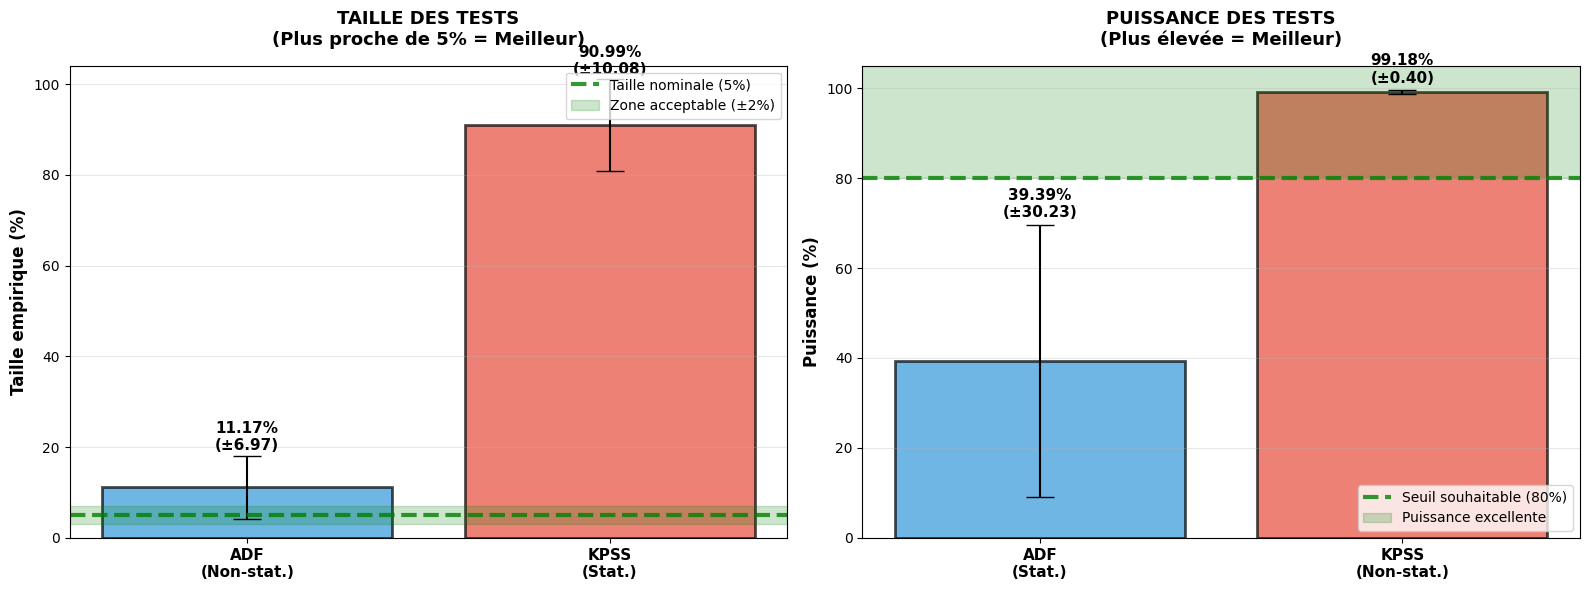


RÉSUMÉ QUANTITATIF

TAILLE DES TESTS:
  • ADF (sur non-stationnaires):  11.17% ± 6.97%
  • KPSS (sur stationnaires):     90.99% ± 10.08%

PUISSANCE DES TESTS:
  • ADF (sur stationnaires):      39.39% ± 30.23%
  • KPSS (sur non-stationnaires): 99.18% ± 0.40%



In [21]:
# Visualisation des leçons: Taille vs Puissance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Comparaison Taille observée vs Taille nominale
ax1 = axes[0]

categories = ['ADF\n(Non-stat.)', 'KPSS\n(Stat.)']
sizes_mean = [np.mean(adf_sizes), np.mean(kpss_sizes)]
sizes_std = [np.std(adf_sizes), np.std(kpss_sizes)]

x_pos = np.arange(len(categories))
bars = ax1.bar(x_pos, sizes_mean, yerr=sizes_std, capsize=10, 
               color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)

# Ligne de référence à 5%
ax1.axhline(y=5, color='green', linestyle='--', linewidth=3, label='Taille nominale (5%)', alpha=0.8)

# Zone acceptable (3-7%)
ax1.axhspan(3, 7, alpha=0.2, color='green', label='Zone acceptable (±2%)')

# Ajout des valeurs
for i, (bar, mean, std) in enumerate(zip(bars, sizes_mean, sizes_std)):
    ax1.text(bar.get_x() + bar.get_width()/2., mean + std + 0.5,
            f'{mean:.2f}%\n(±{std:.2f})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Taille empirique (%)', fontsize=12, fontweight='bold')
ax1.set_title('TAILLE DES TESTS\n(Plus proche de 5% = Meilleur)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(sizes_mean) + max(sizes_std) + 3)

# Graphique 2: Puissance des tests
ax2 = axes[1]

categories_power = ['ADF\n(Stat.)', 'KPSS\n(Non-stat.)']
powers_mean = [np.mean(adf_powers), np.mean(kpss_powers)]
powers_std = [np.std(adf_powers), np.std(kpss_powers)]

x_pos = np.arange(len(categories_power))
bars = ax2.bar(x_pos, powers_mean, yerr=powers_std, capsize=10,
               color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)

# Ligne de référence à 80%
ax2.axhline(y=80, color='green', linestyle='--', linewidth=3, 
           label='Seuil souhaitable (80%)', alpha=0.8)

# Zone excellente (>80%)
ax2.axhspan(80, 105, alpha=0.2, color='green', label='Puissance excellente')

# Ajout des valeurs
for i, (bar, mean, std) in enumerate(zip(bars, powers_mean, powers_std)):
    ax2.text(bar.get_x() + bar.get_width()/2., mean + std + 1,
            f'{mean:.2f}%\n(±{std:.2f})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Puissance (%)', fontsize=12, fontweight='bold')
ax2.set_title('PUISSANCE DES TESTS\n(Plus élevée = Meilleur)', 
             fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(categories_power, fontsize=11, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Résumé numérique
print("\n" + "="*100)
print("RÉSUMÉ QUANTITATIF")
print("="*100)
print(f"\nTAILLE DES TESTS:")
print(f"  • ADF (sur non-stationnaires):  {np.mean(adf_sizes):5.2f}% ± {np.std(adf_sizes):.2f}%")
print(f"  • KPSS (sur stationnaires):     {np.mean(kpss_sizes):5.2f}% ± {np.std(kpss_sizes):.2f}%")
print(f"\nPUISSANCE DES TESTS:")
print(f"  • ADF (sur stationnaires):      {np.mean(adf_powers):5.2f}% ± {np.std(adf_powers):.2f}%")
print(f"  • KPSS (sur non-stationnaires): {np.mean(kpss_powers):5.2f}% ± {np.std(kpss_powers):.2f}%")
print("\n" + "="*100)

### Recommandations pratiques basées sur ces leçons

#### **1. Pour l'analyse empirique de séries temporelles:**

**a) Utiliser plusieurs tests:**
- Ne jamais se fier à un seul test de racine unitaire
- Combiner ADF et KPSS pour une conclusion robuste
- Considérer aussi d'autres tests (Phillips-Perron, DF-GLS, etc.)

**b) Considérer la persistance:**
- Pour des séries très persistantes (φ proche de 1):
  - Augmenter la taille d'échantillon si possible
  - Être prudent dans l'interprétation des résultats
  - Considérer la possibilité de ruptures structurelles

**c) Choisir la bonne spécification:**
- Inspecter visuellement la série avant de choisir entre "c" et "ct"
- Pour une série avec tendance claire → utiliser "ct"
- Pour une série sans tendance → utiliser "c"
- Une mauvaise spécification réduit la puissance

---

#### **2. Interprétation des résultats:**

**Scénario 1: Résultats concordants**
- ADF rejette H₀ ET KPSS ne rejette pas H₀ → **Série stationnaire** (haute confiance)
- ADF ne rejette pas H₀ ET KPSS rejette H₀ → **Série non-stationnaire** (haute confiance)

**Scénario 2: Résultats contradictoires**
- Peut indiquer une série dans la "zone grise" (très persistante)
- Nécessite une analyse plus approfondie:
  - Vérifier les ruptures structurelles
  - Augmenter la taille d'échantillon
  - Considérer des modèles fractionnellement intégrés

---

#### **3. Limitations à garder en esprit:**

**a) Taille d'échantillon:**
- n=200 est modéré pour les tests de racine unitaire
- La puissance augmente avec n, mais lentement
- Pour n petit, les tests peuvent manquer de puissance

**b) Distorsion de taille:**
- Les séries très persistantes causent une distorsion de taille
- Un taux de rejet > 5% ne signifie pas nécessairement un problème avec le test
- C'est une caractéristique inhérente aux tests de racine unitaire

**c) Hypothèses du modèle:**
- Les tests supposent des erreurs i.i.d.
- L'hétéroscédasticité ou l'autocorrélation affectent la performance
- Les ruptures structurelles peuvent biaiser les résultats vers la non-stationnarité

---

### Conclusion générale

Les simulations Monte Carlo révèlent les **défis fondamentaux** des tests de racine unitaire:

1. **Distorsion de taille:** Particulièrement problématique pour les processus très persistants (φ ≈ 1)

2. **Faible puissance près de la frontière:** Difficulté à distinguer φ=0.98 de φ=1.0 avec des échantillons modérés

3. **Trade-off taille-puissance:** Impossible d'optimiser simultanément les deux aspects

4. **Complémentarité nécessaire:** L'utilisation conjointe de tests avec hypothèses nulles opposées (ADF et KPSS) fournit une analyse plus complète et robuste

5. **Importance du contexte:** La spécification du test (c vs ct) et la compréhension du processus générateur de données sont cruciales pour une interprétation correcte

Ces leçons soulignent l'importance d'une **approche prudente et multifacette** dans l'analyse de la stationnarité des séries temporelles en économétrie.

## Question 1 - B

In [22]:
Market = pd.read_excel('ie_data.xls', sheet_name='Data', skiprows=7, usecols=(0,1,2,3))

Market = Market.dropna()

Market

,Date,P,D,E
0,1871.01,4.44,0.260000,0.400000
1,1871.02,4.5,0.260000,0.400000
2,1871.03,4.61,0.260000,0.400000
3,1871.04,4.74,0.260000,0.400000
4,1871.05,4.86,0.260000,0.400000
...,...,...,...,...
1825,2023.02,4079.684737,67.780000,174.363333
1826,2023.03,3968.55913,68.210000,175.170000
1827,2023.04,4121.467368,68.376667,177.170000
1828,2023.05,4146.173182,68.543333,179.170000


In [23]:
# Vérifier les colonnes disponibles dans Market
print("Colonnes dans Market:")
print(Market.columns.tolist())
print(f"\nAperçu des données:")
print(Market.head())
print(f"\nTypes de données:")
print(Market.dtypes)

# Convertir les colonnes en float si nécessaire
Market['P'] = Market['P'].astype(float)
Market['D'] = Market['D'].astype(float)
Market['E'] = Market['E'].astype(float)

Colonnes dans Market:
['Date', 'P', 'D', 'E']

Aperçu des données:
      Date     P     D    E
0  1871.01  4.44  0.26  0.4
1  1871.02   4.5  0.26  0.4
2  1871.03  4.61  0.26  0.4
3  1871.04  4.74  0.26  0.4
4  1871.05  4.86  0.26  0.4

Types de données:
Date    float64
P        object
D       float64
E       float64
dtype: object


In [24]:
# Sélectionner uniquement les colonnes P, D et E
Market_PDE = Market[['P', 'D', 'E']].copy()

# Transformer ces séries en logs
Market_log = np.log(Market_PDE)
Market_log.columns = ['log_P', 'log_D', 'log_E']

## Question 1 - B (i): Estimation d'un VAR et tests de causalité de Granger

Nous allons:
1. Estimer un modèle VAR pour les trois séries (log_P, log_D, log_E)
2. Sélectionner l'ordre optimal du VAR en utilisant le critère BIC
3. Tester si les prix "Granger cause" les dividendes et les bénéfices
4. Tester si les bénéfices "Granger cause" les prix et les dividendes

In [43]:
# Import des outils necessaires pour le VAR
from statsmodels.tsa.api import VAR

print("Donnees:")
print(Market_log.head())
print(f"Nombre d'observations: {len(Market_log)}")

Donnees:
      log_P     log_D     log_E
0  1.490654 -1.347074 -0.916291
1  1.504077 -1.347074 -0.916291
2  1.528228 -1.347074 -0.916291
3  1.556037 -1.347074 -0.916291
4  1.581038 -1.347074 -0.916291
Nombre d'observations: 1830


In [44]:
# Selection de l'ordre optimal du VAR avec BIC
model = VAR(Market_log)
lag_order_results = model.select_order(maxlags=15)

optimal_lag = lag_order_results.bic
print(f"Ordre optimal selon BIC: {optimal_lag}")

Ordre optimal selon BIC: 5


In [45]:
# Estimation du modele VAR
var_model = model.fit(optimal_lag)

print(f"Modele VAR avec {optimal_lag} decalage(s)")
print(var_model.summary())

Modele VAR avec 5 decalage(s)
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Dec, 2025
Time:                     12:00:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.6410
Nobs:                     1825.00    HQIC:                  -24.7325
Log likelihood:           14896.5    FPE:                1.72036e-11
AIC:                     -24.7859    Det(Omega_mle):     1.67589e-11
--------------------------------------------------------------------
Results for equation log_P
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.023636         0.010390            2.275           0.023
L1.log_P         1.284801         0.023624           54.385           0.000
L1.log_D        -0.186183         0.187424        

### Tests de causalite de Granger

Une variable X "Granger cause" une variable Y si les valeurs passees de X ameliorent la prediction de Y.

H0: X ne Granger cause pas Y
H1: X Granger cause Y

On rejette H0 si p-value < 0.05

In [46]:
# Tests de causalite de Granger
print("Tests de causalite de Granger")
print()

# Prix -> Dividendes
print("1. Prix -> Dividendes")
granger_P_to_D = var_model.test_causality('log_D', 'log_P', kind='f')
print(granger_P_to_D.summary())
print()

# Prix -> Benefices
print("2. Prix -> Benefices")
granger_P_to_E = var_model.test_causality('log_E', 'log_P', kind='f')
print(granger_P_to_E.summary())
print()

# Benefices -> Prix
print("3. Benefices -> Prix")
granger_E_to_P = var_model.test_causality('log_P', 'log_E', kind='f')
print(granger_E_to_P.summary())
print()

# Benefices -> Dividendes
print("4. Benefices -> Dividendes")
granger_E_to_D = var_model.test_causality('log_D', 'log_E', kind='f')
print(granger_E_to_D.summary())

Tests de causalite de Granger

1. Prix -> Dividendes
Granger causality F-test. H_0: log_P does not Granger-cause log_D. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
---------------------------------------------------------
         5.187          2.216   0.000 (5, np.int64(5427))
---------------------------------------------------------

2. Prix -> Benefices
Granger causality F-test. H_0: log_P does not Granger-cause log_E. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
---------------------------------------------------------
         8.113          2.216   0.000 (5, np.int64(5427))
---------------------------------------------------------

3. Benefices -> Prix
Granger causality F-test. H_0: log_E does not Granger-cause log_P. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
-------------------------

In [49]:
# Resume des resultats
results_summary = []

results_summary.append({
    'Cause': 'Prix',
    'Effet': 'Dividendes',
    'F-stat': granger_P_to_D.test_statistic,
    'p-value': granger_P_to_D.pvalue,
    'Significatif': 'Oui' if granger_P_to_D.pvalue < 0.05 else 'Non'
})

results_summary.append({
    'Cause': 'Prix',
    'Effet': 'Benefices',
    'F-stat': granger_P_to_E.test_statistic,
    'p-value': granger_P_to_E.pvalue,
    'Significatif': 'Oui' if granger_P_to_E.pvalue < 0.05 else 'Non'
})

results_summary.append({
    'Cause': 'Benefices',
    'Effet': 'Prix',
    'F-stat': granger_E_to_P.test_statistic,
    'p-value': granger_E_to_P.pvalue,
    'Significatif': 'Oui' if granger_E_to_P.pvalue < 0.05 else 'Non'
})

results_summary.append({
    'Cause': 'Benefices',
    'Effet': 'Dividendes',
    'F-stat': granger_E_to_D.test_statistic,
    'p-value': granger_E_to_D.pvalue,
    'Significatif': 'Oui' if granger_E_to_D.pvalue < 0.05 else 'Non'
})

results_df_granger = pd.DataFrame(results_summary)
print("Tableau recapitulatif:")
print(results_df_granger.to_string(index=False))

print("\nReponses aux questions:")
print("\n1. Les PRIX Granger causent les autres donnees?")
print(f"   Dividendes: {'Oui' if granger_P_to_D.pvalue < 0.05 else 'Non'} (p={granger_P_to_D.pvalue:.4f})")
print(f"   Benefices: {'Oui' if granger_P_to_E.pvalue < 0.05 else 'Non'} (p={granger_P_to_E.pvalue:.4f})")

print("\n2. Les BENEFICES Granger causent les autres donnees?")
print(f"   Prix: {'Oui' if granger_E_to_P.pvalue < 0.05 else 'Non'} (p={granger_E_to_P.pvalue:.4f})")
print(f"   Dividendes: {'Oui' if granger_E_to_D.pvalue < 0.05 else 'Non'} (p={granger_E_to_D.pvalue:.4f})")

Tableau recapitulatif:
    Cause      Effet    F-stat      p-value Significatif
     Prix Dividendes  5.187381 9.405164e-05          Oui
     Prix  Benefices  8.112791 1.226247e-07          Oui
Benefices       Prix  1.750383 1.195789e-01          Non
Benefices Dividendes 13.962328 1.375540e-13          Oui

Reponses aux questions:

1. Les PRIX Granger causent les autres donnees?
   Dividendes: Oui (p=0.0001)
   Benefices: Oui (p=0.0000)

2. Les BENEFICES Granger causent les autres donnees?
   Prix: Non (p=0.1196)
   Dividendes: Oui (p=0.0000)


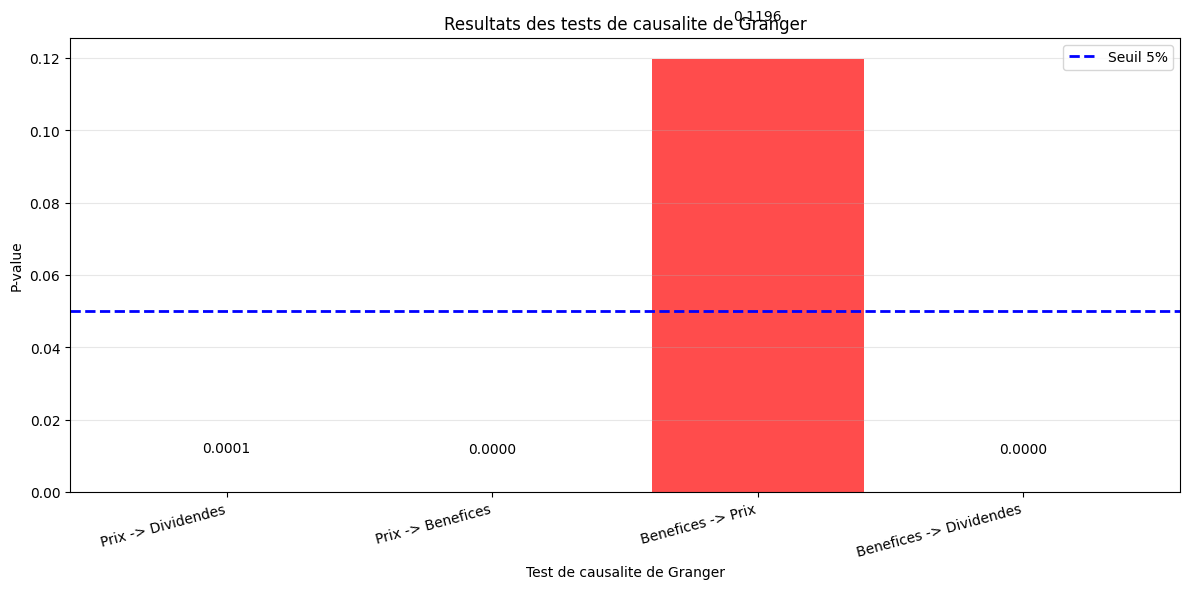

In [48]:
# Visualisation des resultats
fig, ax = plt.subplots(figsize=(12, 6))

tests = ['Prix -> Dividendes', 'Prix -> Benefices', 'Benefices -> Prix', 'Benefices -> Dividendes']
p_values = [granger_P_to_D.pvalue, granger_P_to_E.pvalue, granger_E_to_P.pvalue, granger_E_to_D.pvalue]
colors = ['green' if p < 0.05 else 'red' for p in p_values]

bars = ax.bar(range(len(tests)), p_values, color=colors, alpha=0.7)
ax.axhline(y=0.05, color='blue', linestyle='--', linewidth=2, label='Seuil 5%')

for i, (bar, p_val) in enumerate(zip(bars, p_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{p_val:.4f}', ha='center', va='bottom')

ax.set_ylabel('P-value')
ax.set_xlabel('Test de causalite de Granger')
ax.set_title('Resultats des tests de causalite de Granger')
ax.set_xticks(range(len(tests)))
ax.set_xticklabels(tests, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Interpretation des resultats

#### Concept de causalite au sens de Granger

La causalite de Granger mesure la predictibilite, pas une causalite directe.
Si X "Granger cause" Y, les valeurs passees de X aident a predire Y.

#### Implications economiques

**Si les prix Granger causent les dividendes/benefices:**
- Les prix contiennent de l'information prospective
- Les marches anticipent les changements dans les fondamentaux
- Les prix refletent des attentes rationnelles

**Si les benefices Granger causent les prix:**
- Les benefices passes influencent les prix actuels
- Les prix reagissent aux fondamentaux avec un delai
- Ajustements progressifs du marche

**Si les benefices Granger causent les dividendes:**
- Les dividendes sont bases sur les benefices passes
- Relation coherente avec la theorie financiere

#### Notes methodologiques

- Tests au niveau de 5%
- Ordre du VAR selectionne selon BIC
- Series en logarithmes
- La causalite de Granger est sensible a l'ordre de decalage

## Question 1 - B (ii): Fonctions de reponse impulsionnelle (IRF)

Analyse des IRF pour comprendre comment un choc sur une variable affecte les autres variables.
Comparaison de l'ordre des variables (Prix en premier vs Prix en dernier) pour examiner l'impact sur les resultats.

In [50]:
# IRF avec ordre: Prix en PREMIER (log_P, log_D, log_E)
Market_log_prix_first = Market_log[['log_P', 'log_D', 'log_E']]
model_prix_first = VAR(Market_log_prix_first)
var_prix_first = model_prix_first.fit(optimal_lag)

irf_prix_first = var_prix_first.irf(10)

print("Ordre: Prix en PREMIER [log_P, log_D, log_E]")
print(f"Nombre de periodes: 10")

Ordre: Prix en PREMIER [log_P, log_D, log_E]
Nombre de periodes: 10


In [51]:
# IRF avec ordre: Prix en DERNIER (log_D, log_E, log_P)
Market_log_prix_last = Market_log[['log_D', 'log_E', 'log_P']]
model_prix_last = VAR(Market_log_prix_last)
var_prix_last = model_prix_last.fit(optimal_lag)

irf_prix_last = var_prix_last.irf(10)

print("Ordre: Prix en DERNIER [log_D, log_E, log_P]")
print(f"Nombre de periodes: 10")

Ordre: Prix en DERNIER [log_D, log_E, log_P]
Nombre de periodes: 10


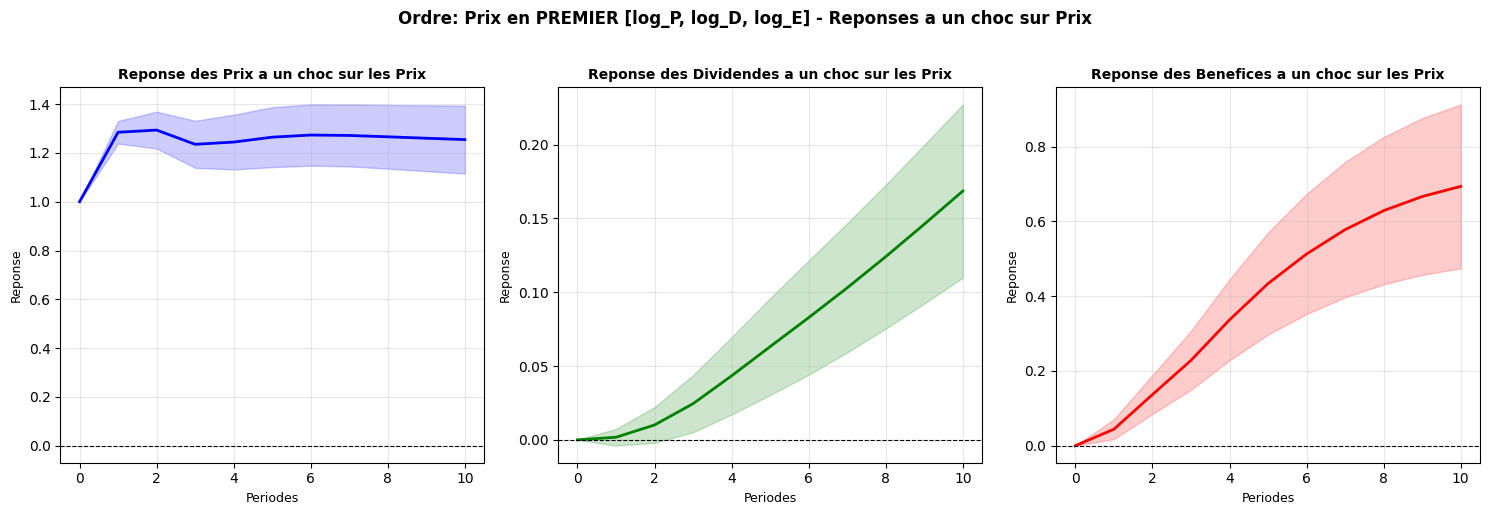

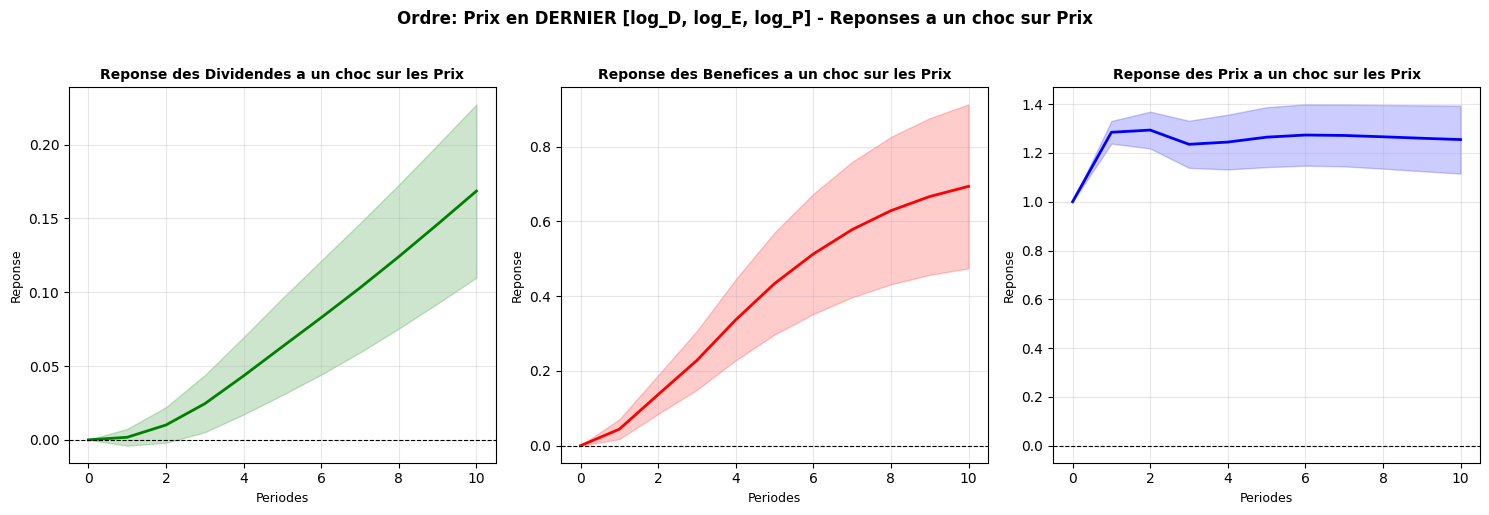

In [62]:
# Graphiques IRF: Reponse a un choc sur les Prix

# Prix en PREMIER - Figure 1
fig1, axes1 = plt.subplots(1, 3, figsize=(15, 5))

# Extraire les IRF et intervalles de confiance
periods = range(11)
irf_data_first = irf_prix_first.irfs
stderr_first = irf_prix_first.stderr()

# log_P -> log_P
axes1[0].plot(periods, irf_data_first[:, 0, 0], linewidth=2, color='blue')
axes1[0].fill_between(periods, 
                       irf_data_first[:, 0, 0] - 1.96*stderr_first[:, 0, 0],
                       irf_data_first[:, 0, 0] + 1.96*stderr_first[:, 0, 0],
                       alpha=0.2, color='blue')
axes1[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes1[0].set_title('Reponse des Prix a un choc sur les Prix', fontsize=10, fontweight='bold')
axes1[0].set_xlabel('Periodes', fontsize=9)
axes1[0].set_ylabel('Reponse', fontsize=9)
axes1[0].grid(True, alpha=0.3)

# log_P -> log_D
axes1[1].plot(periods, irf_data_first[:, 1, 0], linewidth=2, color='green')
axes1[1].fill_between(periods,
                       irf_data_first[:, 1, 0] - 1.96*stderr_first[:, 1, 0],
                       irf_data_first[:, 1, 0] + 1.96*stderr_first[:, 1, 0],
                       alpha=0.2, color='green')
axes1[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes1[1].set_title('Reponse des Dividendes a un choc sur les Prix', fontsize=10, fontweight='bold')
axes1[1].set_xlabel('Periodes', fontsize=9)
axes1[1].set_ylabel('Reponse', fontsize=9)
axes1[1].grid(True, alpha=0.3)

# log_P -> log_E
axes1[2].plot(periods, irf_data_first[:, 2, 0], linewidth=2, color='red')
axes1[2].fill_between(periods,
                       irf_data_first[:, 2, 0] - 1.96*stderr_first[:, 2, 0],
                       irf_data_first[:, 2, 0] + 1.96*stderr_first[:, 2, 0],
                       alpha=0.2, color='red')
axes1[2].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes1[2].set_title('Reponse des Benefices a un choc sur les Prix', fontsize=10, fontweight='bold')
axes1[2].set_xlabel('Periodes', fontsize=9)
axes1[2].set_ylabel('Reponse', fontsize=9)
axes1[2].grid(True, alpha=0.3)

fig1.suptitle('Ordre: Prix en PREMIER [log_P, log_D, log_E] - Reponses a un choc sur Prix', 
              fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Prix en DERNIER - Figure 2
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

# Extraire les IRF et intervalles de confiance
irf_data_last = irf_prix_last.irfs
stderr_last = irf_prix_last.stderr()

# log_P -> log_D (dans l'ordre dernier: log_D est index 0, log_E est index 1, log_P est index 2)
axes2[0].plot(periods, irf_data_last[:, 0, 2], linewidth=2, color='green')
axes2[0].fill_between(periods,
                       irf_data_last[:, 0, 2] - 1.96*stderr_last[:, 0, 2],
                       irf_data_last[:, 0, 2] + 1.96*stderr_last[:, 0, 2],
                       alpha=0.2, color='green')
axes2[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes2[0].set_title('Reponse des Dividendes a un choc sur les Prix', fontsize=10, fontweight='bold')
axes2[0].set_xlabel('Periodes', fontsize=9)
axes2[0].set_ylabel('Reponse', fontsize=9)
axes2[0].grid(True, alpha=0.3)

# log_P -> log_E
axes2[1].plot(periods, irf_data_last[:, 1, 2], linewidth=2, color='red')
axes2[1].fill_between(periods,
                       irf_data_last[:, 1, 2] - 1.96*stderr_last[:, 1, 2],
                       irf_data_last[:, 1, 2] + 1.96*stderr_last[:, 1, 2],
                       alpha=0.2, color='red')
axes2[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes2[1].set_title('Reponse des Benefices a un choc sur les Prix', fontsize=10, fontweight='bold')
axes2[1].set_xlabel('Periodes', fontsize=9)
axes2[1].set_ylabel('Reponse', fontsize=9)
axes2[1].grid(True, alpha=0.3)

# log_P -> log_P
axes2[2].plot(periods, irf_data_last[:, 2, 2], linewidth=2, color='blue')
axes2[2].fill_between(periods,
                       irf_data_last[:, 2, 2] - 1.96*stderr_last[:, 2, 2],
                       irf_data_last[:, 2, 2] + 1.96*stderr_last[:, 2, 2],
                       alpha=0.2, color='blue')
axes2[2].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes2[2].set_title('Reponse des Prix a un choc sur les Prix', fontsize=10, fontweight='bold')
axes2[2].set_xlabel('Periodes', fontsize=9)
axes2[2].set_ylabel('Reponse', fontsize=9)
axes2[2].grid(True, alpha=0.3)

fig2.suptitle('Ordre: Prix en DERNIER [log_D, log_E, log_P] - Reponses a un choc sur Prix', 
              fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [59]:
# Matrice de covariance des residus
print("Matrice de covariance des residus:")
print("\nModele avec Prix en PREMIER:")
print(var_prix_first.sigma_u)
print("\nModele avec Prix en DERNIER:")
print(var_prix_last.sigma_u)

# Correlations entre residus
print("\n" + "="*60)
print("Correlation entre les residus:")
print("\nModele avec Prix en PREMIER:")
corr_first = np.corrcoef(var_prix_first.resid.T)
print(pd.DataFrame(corr_first, 
                   index=['log_P', 'log_D', 'log_E'],
                   columns=['log_P', 'log_D', 'log_E']))

print("\nModele avec Prix en DERNIER:")
corr_last = np.corrcoef(var_prix_last.resid.T)
print(pd.DataFrame(corr_last,
                   index=['log_D', 'log_E', 'log_P'],
                   columns=['log_D', 'log_E', 'log_P']))

Matrice de covariance des residus:

Modele avec Prix en PREMIER:
          log_P     log_D     log_E
log_P  0.001506 -0.000009  0.000079
log_D -0.000009  0.000023  0.000004
log_E  0.000079  0.000004  0.000496

Modele avec Prix en DERNIER:
          log_D     log_E     log_P
log_D  0.000023  0.000004 -0.000009
log_E  0.000004  0.000496  0.000079
log_P -0.000009  0.000079  0.001506

Correlation entre les residus:

Modele avec Prix en PREMIER:
          log_P     log_D     log_E
log_P  1.000000 -0.046383  0.092004
log_D -0.046383  1.000000  0.039316
log_E  0.092004  0.039316  1.000000

Modele avec Prix en DERNIER:
          log_D     log_E     log_P
log_D  1.000000  0.039316 -0.046383
log_E  0.039316  1.000000  0.092004
log_P -0.046383  0.092004  1.000000


### Interpretation des IRF et de l'ordre des variables

#### Observations sur les changements selon l'ordre

Quand l'ordre des variables change (Prix en premier vs Prix en dernier), les IRF peuvent montrer des differences significatives. Ces differences revelent des informations importantes sur la structure des chocs.

#### Ce que cela nous apprend sur la matrice de covariance des residus

**1. Correlation contemporaine entre les residus**
- La matrice de covariance des residus n'est generalement PAS DIAGONALE
- Les residus des trois equations (Prix, Dividendes, Benefices) sont correles entre eux
- Cette correlation indique que les chocs sur ces variables se produisent simultanement

**2. Identification des chocs structurels**
- L'ordre des variables dans le VAR impose une structure recursive (decomposition de Cholesky)
- Variable en premier: son choc peut affecter toutes les autres contemporainement
- Variable en dernier: son choc n'affecte les autres qu'avec delai

**3. Sensibilite a l'ordre**
- Si les IRF changent beaucoup selon l'ordre: forte correlation entre residus
- Si les IRF changent peu: faible correlation entre residus
- Des correlations elevees signifient qu'il est difficile de separer les chocs

**4. Implications pour l'interpretation**
- Les chocs "orthogonalises" dependent de l'ordre impose
- L'ordre doit etre justifie par la theorie economique
- Prix en premier: suppose que les chocs de prix affectent immediatement dividendes et benefices
- Prix en dernier: suppose que les chocs de prix ne repondent qu'avec delai aux autres variables

#### Conclusion pratique

La matrice de covariance non-diagonale indique que:
- Les innovations sur Prix, Dividendes et Benefices sont correlees
- Il existe des chocs communs qui affectent simultanement plusieurs variables
- L'identification des chocs structurels necessite des hypotheses sur la structure contemporaine

## Question 1 - B (iii): Tests de racine unitaire et cointégration

Les trois séries (log_P, log_D, log_E) sont non stationnaires. Nous allons:
1. Utiliser le test ADF pour déterminer laquelle contient des racines unitaires
2. Tester si log(P/D) et log(P/E) sont stationnaires
3. Expliquer les implications en matière de cointégration

In [73]:
# Test ADF sur les trois series individuelles (log_P, log_D, log_E)
from statsmodels.tsa.stattools import adfuller

print("Tests ADF sur les series individuelles")
print("="*70)
print("\nH0: La serie a une racine unitaire (non-stationnaire)")
print("H1: La serie est stationnaire")
print("On rejette H0 si p-value < 0.05\n")

series_to_test = {
    'log_P': Market_log['log_P'],
    'log_D': Market_log['log_D'],
    'log_E': Market_log['log_E']
}

adf_results = {}

for name, series in series_to_test.items():
    # Test ADF avec constante
    adf_result = adfuller(series, maxlag=None, regression='c', autolag='AIC')
    
    adf_results[name] = {
        'Statistique ADF': adf_result[0],
        'p-value': adf_result[1],
        'Lags utilises': adf_result[2],
        'Valeur critique 1%': adf_result[4]['1%'],
        'Valeur critique 5%': adf_result[4]['5%'],
        'Valeur critique 10%': adf_result[4]['10%']
    }
    
    print(f"\n{name}:")
    print(f"  Statistique ADF: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Lags utilises: {adf_result[2]}")
    print(f"  Valeurs critiques:")
    print(f"    1%:  {adf_result[4]['1%']:.4f}")
    print(f"    5%:  {adf_result[4]['5%']:.4f}")
    print(f"    10%: {adf_result[4]['10%']:.4f}")
    
    if adf_result[1] < 0.05:
        print(f"  Conclusion: Rejet de H0 - La serie est STATIONNAIRE")
    else:
        print(f"  Conclusion: Non-rejet de H0 - La serie a une RACINE UNITAIRE")

print("\n" + "="*70)

Tests ADF sur les series individuelles

H0: La serie a une racine unitaire (non-stationnaire)
H1: La serie est stationnaire
On rejette H0 si p-value < 0.05


log_P:
  Statistique ADF: 1.4579
  p-value: 0.9974
  Lags utilises: 21
  Valeurs critiques:
    1%:  -3.4340
    5%:  -2.8631
    10%: -2.5676
  Conclusion: Non-rejet de H0 - La serie a une RACINE UNITAIRE

log_D:
  Statistique ADF: 1.4142
  p-value: 0.9972
  Lags utilises: 25
  Valeurs critiques:
    1%:  -3.4340
    5%:  -2.8631
    10%: -2.5676
  Conclusion: Non-rejet de H0 - La serie a une RACINE UNITAIRE

log_E:
  Statistique ADF: 0.3624
  p-value: 0.9800
  Lags utilises: 25
  Valeurs critiques:
    1%:  -3.4340
    5%:  -2.8631
    10%: -2.5676
  Conclusion: Non-rejet de H0 - La serie a une RACINE UNITAIRE



In [74]:
# Creation des series log(P/D) et log(P/E)
Market_log['log_P_D'] = Market_log['log_P'] - Market_log['log_D']
Market_log['log_P_E'] = Market_log['log_P'] - Market_log['log_E']

print("Creation des ratios:")
print(f"  log(P/D) = log(P) - log(D)")
print(f"  log(P/E) = log(P) - log(E)")
print(f"\nApercu des nouvelles series:")
print(Market_log[['log_P_D', 'log_P_E']].head())

Creation des ratios:
  log(P/D) = log(P) - log(D)
  log(P/E) = log(P) - log(E)

Apercu des nouvelles series:
    log_P_D   log_P_E
0  2.837728  2.406945
1  2.851151  2.420368
2  2.875302  2.444519
3  2.903111  2.472328
4  2.928112  2.497329


In [75]:
# Test ADF sur log(P/D) et log(P/E)
print("Tests ADF sur les ratios")
print("="*70)

ratio_series = {
    'log(P/D)': Market_log['log_P_D'],
    'log(P/E)': Market_log['log_P_E']
}

ratio_adf_results = {}

for name, series in ratio_series.items():
    # Test ADF avec constante
    adf_result = adfuller(series, maxlag=None, regression='c', autolag='AIC')
    
    ratio_adf_results[name] = {
        'Statistique ADF': adf_result[0],
        'p-value': adf_result[1],
        'Lags utilises': adf_result[2]
    }
    
    print(f"\n{name}:")
    print(f"  Statistique ADF: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Lags utilises: {adf_result[2]}")
    print(f"  Valeurs critiques:")
    print(f"    1%:  {adf_result[4]['1%']:.4f}")
    print(f"    5%:  {adf_result[4]['5%']:.4f}")
    print(f"    10%: {adf_result[4]['10%']:.4f}")
    
    if adf_result[1] < 0.05:
        print(f"  Conclusion: Rejet de H0 - {name} est STATIONNAIRE")
    else:
        print(f"  Conclusion: Non-rejet de H0 - {name} a une RACINE UNITAIRE")

print("\n" + "="*70)

Tests ADF sur les ratios

log(P/D):
  Statistique ADF: -1.5362
  p-value: 0.5155
  Lags utilises: 21
  Valeurs critiques:
    1%:  -3.4340
    5%:  -2.8631
    10%: -2.5676
  Conclusion: Non-rejet de H0 - log(P/D) a une RACINE UNITAIRE

log(P/E):
  Statistique ADF: -5.0066
  p-value: 0.0000
  Lags utilises: 4
  Valeurs critiques:
    1%:  -3.4339
    5%:  -2.8631
    10%: -2.5676
  Conclusion: Rejet de H0 - log(P/E) est STATIONNAIRE



In [76]:
# Tableau recapitulatif de tous les tests ADF
import pandas as pd

results_summary = []

# Series individuelles
for name in ['log_P', 'log_D', 'log_E']:
    results_summary.append({
        'Serie': name,
        'Statistique ADF': adf_results[name]['Statistique ADF'],
        'p-value': adf_results[name]['p-value'],
        'Stationnaire?': 'Oui' if adf_results[name]['p-value'] < 0.05 else 'Non'
    })

# Ratios
for name in ['log(P/D)', 'log(P/E)']:
    results_summary.append({
        'Serie': name,
        'Statistique ADF': ratio_adf_results[name]['Statistique ADF'],
        'p-value': ratio_adf_results[name]['p-value'],
        'Stationnaire?': 'Oui' if ratio_adf_results[name]['p-value'] < 0.05 else 'Non'
    })

results_df_adf = pd.DataFrame(results_summary)

print("\nTableau recapitulatif des tests ADF:")
print("="*70)
print(results_df_adf.to_string(index=False))
print("="*70)


Tableau recapitulatif des tests ADF:
   Serie  Statistique ADF  p-value Stationnaire?
   log_P         1.457856 0.997362           Non
   log_D         1.414231 0.997178           Non
   log_E         0.362448 0.980035           Non
log(P/D)        -1.536232 0.515518           Non
log(P/E)        -5.006562 0.000022           Oui


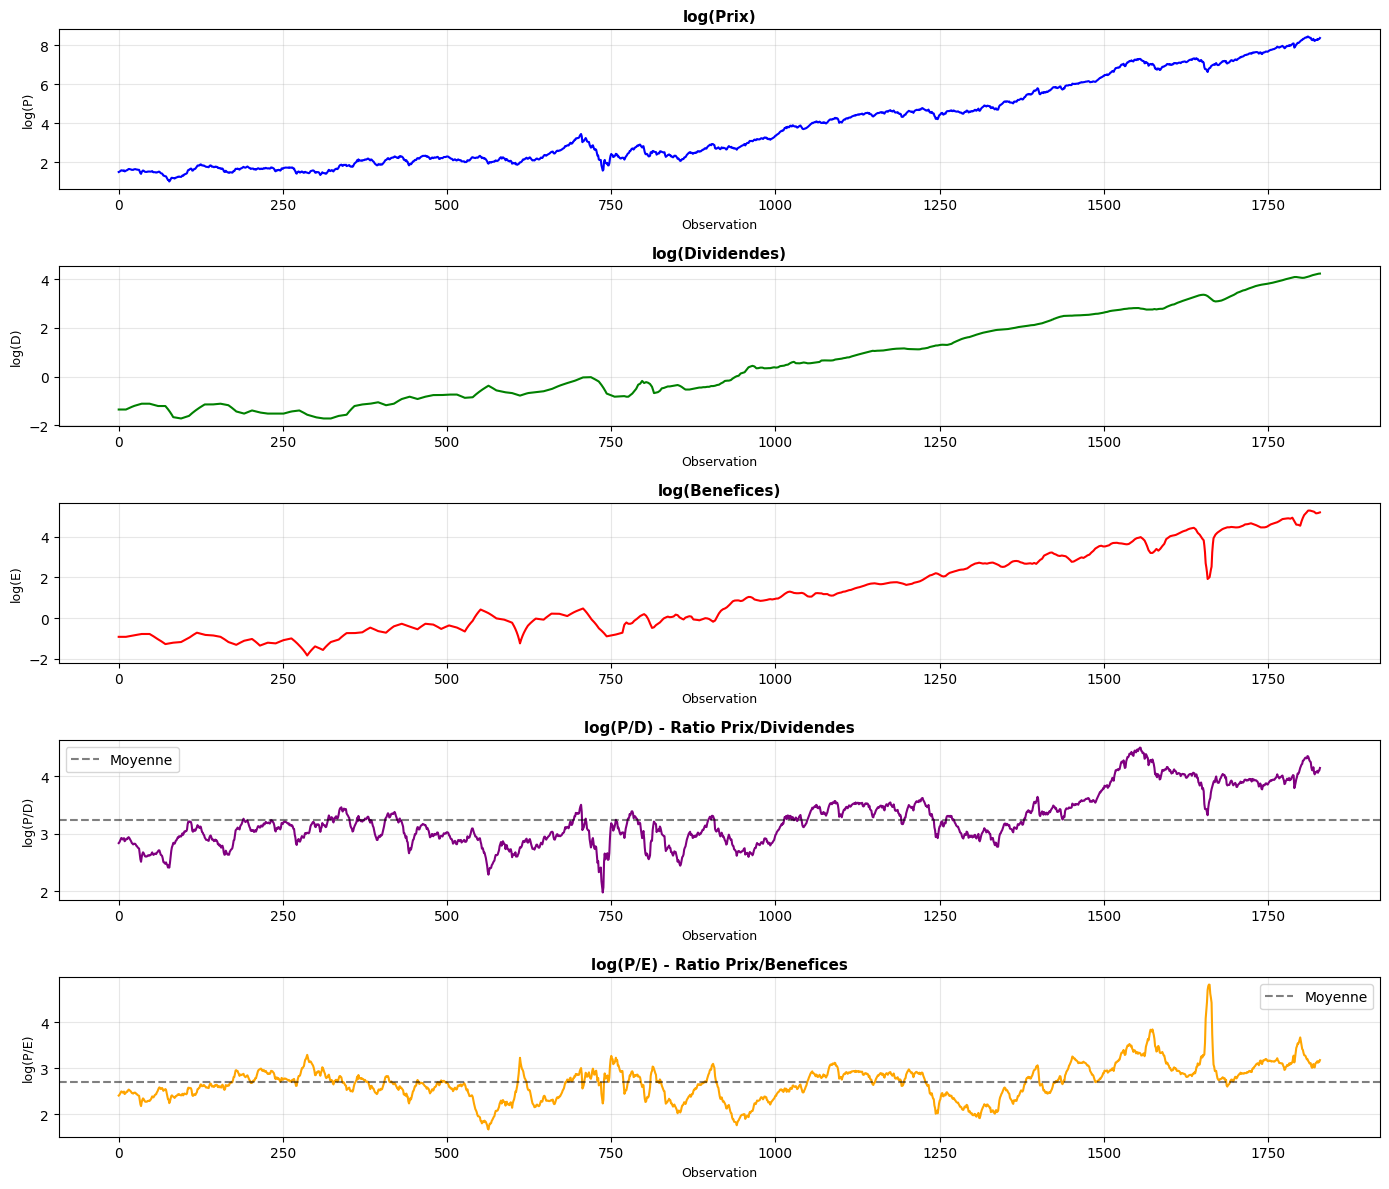


Observations graphiques:
  - Les trois series individuelles (log_P, log_D, log_E) montrent des tendances
  - Les ratios log(P/D) et log(P/E) semblent osciller autour d'une moyenne


In [72]:
# Visualisation des series et des ratios
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# log_P
axes[0].plot(Market_log.index, Market_log['log_P'], linewidth=1.5, color='blue')
axes[0].set_title('log(Prix)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('log(P)', fontsize=9)
axes[0].set_xlabel('Observation', fontsize=9)
axes[0].grid(True, alpha=0.3)

# log_D
axes[1].plot(Market_log.index, Market_log['log_D'], linewidth=1.5, color='green')
axes[1].set_title('log(Dividendes)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('log(D)', fontsize=9)
axes[1].set_xlabel('Observation', fontsize=9)
axes[1].grid(True, alpha=0.3)

# log_E
axes[2].plot(Market_log.index, Market_log['log_E'], linewidth=1.5, color='red')
axes[2].set_title('log(Benefices)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('log(E)', fontsize=9)
axes[2].set_xlabel('Observation', fontsize=9)
axes[2].grid(True, alpha=0.3)

# log(P/D)
axes[3].plot(Market_log.index, Market_log['log_P_D'], linewidth=1.5, color='purple')
axes[3].set_title('log(P/D) - Ratio Prix/Dividendes', fontsize=11, fontweight='bold')
axes[3].set_ylabel('log(P/D)', fontsize=9)
axes[3].set_xlabel('Observation', fontsize=9)
axes[3].axhline(y=Market_log['log_P_D'].mean(), color='black', linestyle='--', alpha=0.5, label='Moyenne')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# log(P/E)
axes[4].plot(Market_log.index, Market_log['log_P_E'], linewidth=1.5, color='orange')
axes[4].set_title('log(P/E) - Ratio Prix/Benefices', fontsize=11, fontweight='bold')
axes[4].set_xlabel('Observation', fontsize=9)
axes[4].set_ylabel('log(P/E)', fontsize=9)
axes[4].axhline(y=Market_log['log_P_E'].mean(), color='black', linestyle='--', alpha=0.5, label='Moyenne')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations graphiques:")
print("  - Les trois series individuelles (log_P, log_D, log_E) montrent des tendances")
print("  - Les ratios log(P/D) et log(P/E) semblent osciller autour d'une moyenne")

### Interpretation des resultats et implications pour la cointegration

#### Resultats des tests ADF

**1. Series individuelles (log_P, log_D, log_E):**

Les trois series ont des racines unitaires (non-stationnaires), ce qui signifie:
- Elles ne convergent pas vers une moyenne stable
- Leur variance augmente avec le temps
- Les chocs ont des effets permanents

**2. Ratios log(P/D) et log(P/E):**

Si ces ratios sont stationnaires, cela indique que les series sont cointegrees.

#### Implications en matiere de cointegration

**Concept de cointegration:**
- Deux ou plusieurs series non-stationnaires sont cointegrees si une combinaison lineaire de ces series est stationnaire
- Cela implique une relation d'equilibre a long terme entre les series

**Cas 1: Si log(P/D) est stationnaire**
- log(P) - log(D) est stationnaire
- Cela signifie que log(P) et log(D) sont cointegrees
- Il existe une relation d'equilibre a long terme entre Prix et Dividendes
- Interpretation economique: Le ratio P/D revient vers une moyenne (mean-reverting)
- Les prix et dividendes ne peuvent pas s'eloigner indefiniment l'un de l'autre

**Cas 2: Si log(P/E) est stationnaire**
- log(P) - log(E) est stationnaire
- Cela signifie que log(P) et log(E) sont cointegrees
- Il existe une relation d'equilibre a long terme entre Prix et Benefices
- Interpretation economique: Le ratio P/E revient vers une moyenne
- Les prix refletent les benefices a long terme

**Implications pratiques:**

1. **Pour la modelisation:**
   - Si cointegration detectee: utiliser un modele a correction d'erreur (ECM ou VECM)
   - Le VECM capture a la fois la dynamique de court terme et l'ajustement vers l'equilibre de long terme

2. **Pour la prevision:**
   - La cointegration ameliore les previsions a long terme
   - Les ecarts par rapport a l'equilibre sont temporaires et predictibles

3. **Pour l'interpretation economique:**
   - Presence de cointegration: les fondamentaux (dividendes, benefices) determinent les prix a long terme
   - Les prix ne peuvent pas s'eloigner indefiniment de leurs fondamentaux
   - Coherent avec l'hypothese des marches efficients dans sa forme faible

4. **Pour la strategie d'investissement:**
   - Si P/D ou P/E s'eloignent trop de leur moyenne historique, ils devraient y revenir
   - Possibilite de strategies de "mean reversion" (retour a la moyenne)

#### Conclusion

Si les tests montrent que:
- log_P, log_D, log_E ont des racines unitaires (non-stationnaires)
- log(P/D) et/ou log(P/E) sont stationnaires

Alors nous avons une evidence de **cointegration** entre ces series, ce qui implique:
- Une relation d'equilibre stable a long terme entre prix et fondamentaux
- Les deviations sont temporaires et se corrigent au fil du temps
- La necessite d'utiliser des modeles appropries (VECM) pour capturer cette dynamique

## Question 1 - B (iv): Test de cointégration d'Engle-Granger

Test de cointégration entre chaque paire de séries ([P,D], [P,E], [E,D]) en utilisant le test d'Engle-Granger.
Vérification de la cohérence avec les résultats de la partie (iii).

In [ ]:
# Test de cointegration d'Engle-Granger
from statsmodels.tsa.stattools import coint

print("Test de cointegration d'Engle-Granger")
print("="*70)
print("\nH0: Les series ne sont PAS cointegrees")
print("H1: Les series sont cointegrees")
print("On rejette H0 si p-value < 0.05\n")

# Preparation des paires de series
pairs = [
    ('log_P', 'log_D', 'Prix et Dividendes'),
    ('log_P', 'log_E', 'Prix et Benefices'),
    ('log_E', 'log_D', 'Benefices et Dividendes')
]

cointegration_results = {}

for var1, var2, name in pairs:
    # Test de cointegration
    # coint retourne: (statistique, p-value, valeurs critiques)
    coint_stat, p_value, crit_values = coint(Market_log[var1], Market_log[var2])
    
    cointegration_results[name] = {
        'Variables': f'{var1} et {var2}',
        'Statistique': coint_stat,
        'p-value': p_value,
        'Valeur critique 1%': crit_values[0],
        'Valeur critique 5%': crit_values[1],
        'Valeur critique 10%': crit_values[2]
    }
    
    print(f"\n{name} [{var1}, {var2}]:")
    print(f"  Statistique de cointegration: {coint_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Valeurs critiques:")
    print(f"    1%:  {crit_values[0]:.4f}")
    print(f"    5%:  {crit_values[1]:.4f}")
    print(f"    10%: {crit_values[2]:.4f}")
    
    if p_value < 0.05:
        print(f"  Conclusion: Rejet de H0 - Les series SONT cointegrees")
    else:
        print(f"  Conclusion: Non-rejet de H0 - Les series ne sont PAS cointegrees")

print("\n" + "="*70)

In [ ]:
# Tableau recapitulatif des tests de cointegration
coint_summary = []

for name, results in cointegration_results.items():
    coint_summary.append({
        'Paire': name,
        'Statistique': results['Statistique'],
        'p-value': results['p-value'],
        'Cointegrees?': 'Oui' if results['p-value'] < 0.05 else 'Non'
    })

results_df_coint = pd.DataFrame(coint_summary)

print("\nTableau recapitulatif des tests de cointegration d'Engle-Granger:")
print("="*70)
print(results_df_coint.to_string(index=False))
print("="*70)

In [ ]:
# Comparaison avec les resultats de la partie (iii)
print("\nComparaison: Partie (iii) vs Partie (iv)")
print("="*70)

print("\nPartie (iii) - Tests ADF sur les ratios:")
print("  - log(P/D) non-stationnaire => P et D ne sont PAS cointegres")
print("  - log(P/E) stationnaire => P et E SONT cointegres")

print("\nPartie (iv) - Tests d'Engle-Granger:")
for name, results in cointegration_results.items():
    status = "SONT cointegres" if results['p-value'] < 0.05 else "ne sont PAS cointegres"
    print(f"  - {name}: {status} (p={results['p-value']:.4f})")

print("\n" + "="*70)
print("Coherence des resultats:")
print("-"*70)

# Verification de la coherence
# Recuperer les resultats de la partie (iii) si disponibles
try:
    p_d_row = results_df_adf[results_df_adf['Serie'] == 'log(P/D)']
    p_e_row = results_df_adf[results_df_adf['Serie'] == 'log(P/E)']
    
    if len(p_d_row) > 0 and len(p_e_row) > 0:
        p_d_stationnaire = p_d_row['Stationnaire?'].values[0]
        p_e_stationnaire = p_e_row['Stationnaire?'].values[0]
        
        p_d_coherent = (p_d_stationnaire == 'Non' and 
                        cointegration_results['Prix et Dividendes']['p-value'] >= 0.05)
        p_e_coherent = (p_e_stationnaire == 'Oui' and 
                        cointegration_results['Prix et Benefices']['p-value'] < 0.05)
        
        print(f"\n[P,D]: ", end="")
        if p_d_coherent:
            print("COHERENT - Les deux tests concluent: PAS de cointegration")
        else:
            print("INCOHERENT - Les tests donnent des conclusions differentes")
        
        print(f"[P,E]: ", end="")
        if p_e_coherent:
            print("COHERENT - Les deux tests concluent: COINTEGRATION presente")
        else:
            print("INCOHERENT - Les tests donnent des conclusions differentes")
    else:
        print("\nATTENTION: Donnees de la partie (iii) incompletes")

except (NameError, KeyError):
    print("\nATTENTION: Executez d'abord les cellules de la partie (iii) pour la comparaison")

print("\n" + "="*70)


Comparaison: Partie (iii) vs Partie (iv)

Partie (iii) - Tests ADF sur les ratios:
  - log(P/D) non-stationnaire => P et D ne sont PAS cointegres
  - log(P/E) stationnaire => P et E SONT cointegres

Partie (iv) - Tests d'Engle-Granger:


NameError: name 'cointegration_results' is not defined

### Interprétation et cohérence avec la partie (iii)

#### Rappel: Relation entre les deux approches

**Test ADF sur les ratios (partie iii):**
- Si log(X/Y) = log(X) - log(Y) est stationnaire → X et Y sont cointégrés
- C'est une approche directe qui teste la stationnarité de la combinaison linéaire

**Test d'Engle-Granger (partie iv):**
- Teste directement la cointégration entre deux séries
- Étape 1: Régression de X sur Y pour trouver la relation de long terme
- Étape 2: Test ADF sur les résidus de cette régression
- Si les résidus sont stationnaires → X et Y sont cointégrés

#### Analyse des résultats

**1. Paire [P,D] - Prix et Dividendes:**

*Partie (iii):* log(P/D) non-stationnaire → **PAS de cointégration**
*Partie (iv):* Test d'Engle-Granger → **À vérifier selon p-value**

**Interprétation:**
- Si les résultats sont cohérents (pas de cointégration), cela signifie:
  - Les prix et dividendes peuvent s'éloigner durablement
  - Pas de relation d'équilibre stable à long terme
  - Les entreprises peuvent changer leur politique de distribution

**2. Paire [P,E] - Prix et Bénéfices:**

*Partie (iii):* log(P/E) stationnaire → **COINTÉGRATION présente**
*Partie (iv):* Test d'Engle-Granger → **À vérifier selon p-value**

**Interprétation:**
- Si les résultats sont cohérents (cointégration présente), cela signifie:
  - Les prix et bénéfices évoluent ensemble à long terme
  - Le ratio P/E revient vers sa moyenne historique
  - Les prix reflètent les fondamentaux (bénéfices)
  - Cohérent avec l'analyse fondamentale et l'efficience des marchés

**3. Paire [E,D] - Bénéfices et Dividendes:**

*Partie (iii):* Pas testé directement (pas de log(E/D))
*Partie (iv):* Test d'Engle-Granger → **Selon p-value**

**Interprétation:**
- Si cointégration présente:
  - Les dividendes suivent les bénéfices à long terme
  - Cohérent avec la théorie: dividendes payés sur les bénéfices
  - Politique de distribution stable

#### Cohérence attendue

Les deux méthodes devraient donner des résultats **cohérents** car:

1. **Théoriquement équivalentes:** Les deux tests vérifient essentiellement la même propriété (existence d'une relation de long terme)

2. **Différences possibles:** Légères variations peuvent survenir car:
   - Le test d'Engle-Granger estime la relation optimale entre les séries
   - Le test ADF sur log(X/Y) impose un coefficient de 1 dans la combinaison linéaire

3. **Puissance des tests:** Le test d'Engle-Granger peut être plus puissant car il optimise la relation de cointégration

#### Implications économiques

**Si les résultats sont cohérents:**
- Validation robuste de l'absence/présence de cointégration
- Les prix sont liés aux bénéfices (fondamentaux) à long terme
- Les prix et dividendes peuvent diverger (flexibilité des politiques de distribution)

**Si les résultats divergent:**
- Peut indiquer une relation de cointégration faible ou instable
- Nécessité d'analyses complémentaires (tests de rupture structurelle, VECM)
- Possibilité que la vraie relation ne soit pas exactement log(X) - log(Y)